In [1]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import IPython
import itertools, os, sys

sys.path.append('..')
from data.load_data import *
from src.map import *
from src.robot import *
from src.slam import *
from src.utils import *

In [2]:
import pickle

MAP_XLIM = (-25, 25)
MAP_YLIM = (-25, 25)
MAP_RESOLUTION = 0.1

belief = 0.8
MAP_LOGODDS_OCCUPIED_DIFF = np.log(belief/(1-belief))
MAP_LOGODDS_FREE_DIFF = np.log((1-belief)/belief)*.5
MAP_LOGODDS_LIM = (-100, 100)

N_PARTICLES = 128
N_EFF_THRESHOLD = 4
PREDICT_NOISE_SIGMA = np.diag([1e-3, 1e-3, 1e-3])
MAP_LOGODDS_OCCUPIED_THRESHOLD = np.log(9)

SAVE_MAP_FIG_FNAME_TEMPLATE = '../fig/MAP_2/{}.jpg'
SAVE_MAP_TEXTURE_FIG_FNAME_TEMPLATE = None

with open('../data/train2.pkl', 'rb') as f:
    datas = pickle.load(f)

In [3]:
from p2_utils import *
from multiprocessing import Pool
import cv2

logodds = Map2D(xlim=MAP_XLIM, ylim=MAP_YLIM, resolution=MAP_RESOLUTION)

state = { 'x': 0, 'y': 0, 'theta': 0 }
for di, data in enumerate(datas):
    for i, key in enumerate(['x', 'y', 'theta']):
        state[key] += data['lidar_delta_pose'][0, i]
        
    if di % 1 == 0:
        lidar_scan = data['lidar_scan']
        lidar_scan_points = np.hstack([data['lidar_scan_points'], np.ones((data['lidar_scan_points'].shape[0], 1))])
        t = Transform(**state, **data)
        lidar_scan_points_w = t.chain('wTb', 'bTh', 'hTl') @ lidar_scan_points.T
        lidar_scan_points_w = lidar_scan_points_w.T[:, :3]
        lidar_scan_points_w = lidar_scan_points_w[lidar_scan_points_w[:, 2] > 0.1, :]
        lidar_scan_points_w = lidar_scan_points_w[logodds.in_map(lidar_scan_points_w), :2]
        
        lidar_scan_indices = logodds.coordinate_to_index(lidar_scan_points_w)
        
        mask = cv2.drawContours(image=np.zeros_like(logodds.data), 
                                contours=[lidar_scan_indices.reshape((-1,1,2)).astype(np.int32)], 
                                contourIdx =-1, 
                                color = MAP_LOGODDS_FREE_DIFF, 
                                thickness=-1)
        logodds.data += mask
        logodds.data[lidar_scan_indices[:, 1], lidar_scan_indices[:, 0]] += MAP_LOGODDS_OCCUPIED_DIFF - MAP_LOGODDS_FREE_DIFF
        logodds.data = np.clip(logodds.data, *MAP_LOGODDS_LIM)
        
logodds.data.max()

100.0

1.0 0.0
(501, 501)


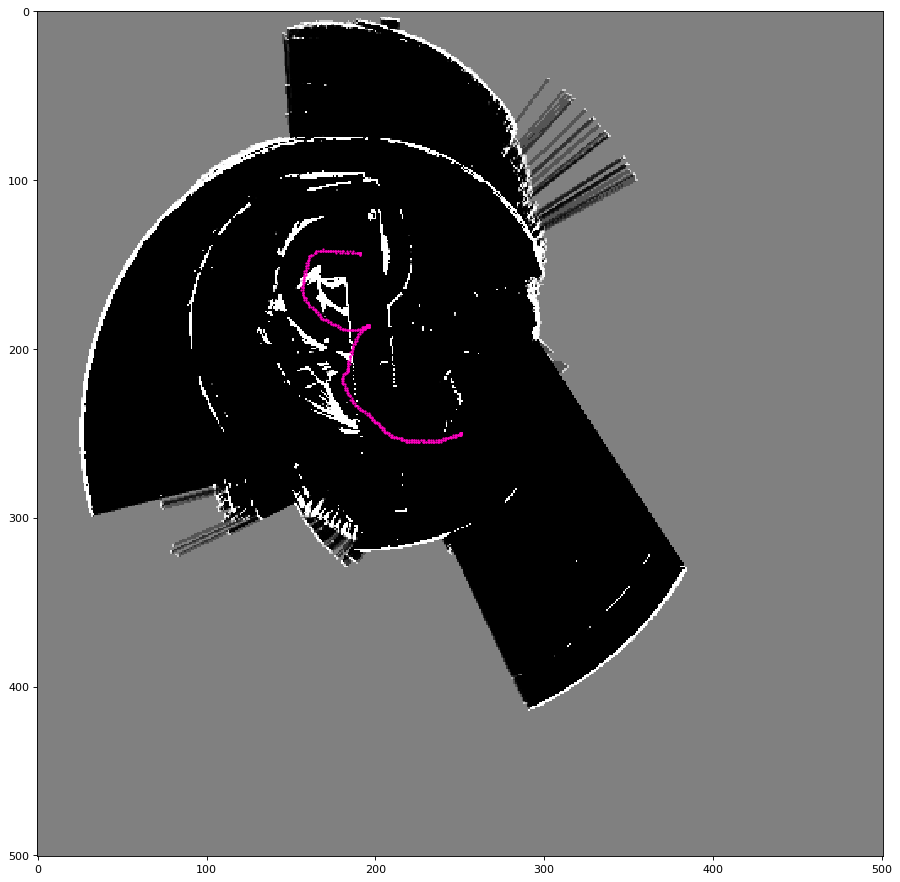

In [4]:
import pylab
from src.util import *

gamma = 1.0 - 1.0/(1.0 + np.exp(logodds.data))
print(gamma.max(), gamma.min())
print(logodds.data.shape)

state = np.array([0, 0, 0], dtype=np.float64)
posx = []
posy = []

for i, data in enumerate(datas):
    state[0] += data['lidar_delta_pose'][0, 0]
    state[1] += data['lidar_delta_pose'][0, 1]
    state[2] += data['lidar_delta_pose'][0, 2]
    
    x, y = logodds.coordinate_to_index([state[0], state[1]]).reshape(-1)
    if i % 20 == 0:
        posx.append(x)
        posy.append(y)

plot_map(gamma, [posx, posy], 20)

In [5]:
%load_ext autoreload
%autoreload 2
from src.slam import ParticleFilterSLAM

slam = ParticleFilterSLAM(
    n_particles=N_PARTICLES,
    n_efficient_threshold=N_EFF_THRESHOLD,
    map_xlim=MAP_XLIM,
    map_ylim=MAP_YLIM,
    map_resolution=MAP_RESOLUTION,
    map_logodds_lim=MAP_LOGODDS_LIM,
    map_logodds_occupied_diff=MAP_LOGODDS_OCCUPIED_DIFF,
    map_logodds_free_diff=MAP_LOGODDS_FREE_DIFF,
    map_logodds_occupied_threshold=MAP_LOGODDS_OCCUPIED_THRESHOLD,
    predict_noise_sigma=PREDICT_NOISE_SIGMA
)

states = [np.array([0, 0, 0])]
for i, data in enumerate(datas):
    with slam.set_robot_data(**data):
        u = slam.predict_particles(data['lidar_delta_pose'][0, :])
        corr, neff = slam.update_particles()

        states.append(slam.robot_state)

        if i % 1 == 0:
            print(i, slam.robot_state, neff, corr.max(), corr.min())
            slam.update_map_logodds()
        
#         if i % 1000 == 0:
#             slam.update_map_texture()
                    
            
        if i % 50 == 0:
            if SAVE_MAP_FIG_FNAME_TEMPLATE is not None:
                fname = SAVE_MAP_FIG_FNAME_TEMPLATE.format(i)

                indices = slam.coordinate_to_map_index(np.array(states))
                save_map_fig(1.0 - slam.map_prob, fname,
                             pos=[indices[::5, 0], indices[::5, 1]], npos=np.ceil(len(datas)/5), size=20)
                
            if SAVE_MAP_TEXTURE_FIG_FNAME_TEMPLATE is not None:
                fname = SAVE_MAP_TEXTURE_FIG_FNAME_TEMPLATE.format(i)

                indices = slam.coordinate_to_map_index(np.array(states))
                save_map_fig(slam.map_texture_trimmed, fname,
                             pos=[indices[::5, 0], indices[::5, 1]], npos=np.ceil(len(datas)/5), size=20)
        plt.close('all')

0 [-0.21190288 -0.26336965 -0.00027017] 127.99999999999997 0.0 0.0
1 [-0.39362    -0.42873604  0.0165477 ] 127.99999999999997 0.0 0.0
2 [-0.39416367 -0.45412568  0.0193975 ] 1.0367100726577665 60.0 11.0
3 [-0.37597238 -0.43071256  0.01845018] 1.002006373537768 325.0 95.0
4 [-0.39643536 -0.44108427  0.01923357] 1.0 630.0 159.0
5 [-0.39235483 -0.42901464  0.01542652] 1.0000000000013642 677.0 121.0
6 [-0.37539175 -0.43577856  0.01540907] 1.0000002250703928 668.0 181.0
7 [-0.39499852 -0.43120295  0.01727314] 1.0000006123624219 703.0 156.0
8 [-0.38176695 -0.44517758  0.01476743] 1.0002468213262967 684.0 179.0
9 [-0.36979084 -0.44378648  0.02028566] 1.0993629071447941 701.0 154.0
10 [-0.36350429 -0.43373712  0.01753483] 1.000000000075488 696.0 161.0
11 [-0.37629321 -0.42924108  0.01748446] 1.000670925190488 716.0 190.0
12 [-0.37545916 -0.42525571  0.01642566] 1.0000000000038654 718.0 152.0
13 [-0.38248137 -0.42666854  0.01825481] 1.0000000015204478 713.0 166.0
14 [-0.37497718 -0.44619098  0.

115 [-0.3557566  -0.44599603  0.01811819] 1.0993676412252134 714.0 222.0
116 [-0.38244885 -0.43927104  0.01539716] 1.2808149767569867 708.0 172.0
117 [-0.35495227 -0.45342907  0.02068111] 1.1000305033089834 703.0 232.0
118 [-0.34729001 -0.44505951  0.01310099] 1.2808192542731967 705.0 217.0
119 [-0.3507057  -0.44452434  0.01764597] 1.000000060920003 712.0 166.0
120 [-0.35250653 -0.43648719  0.01660943] 1.0993350553696433 708.0 172.0
121 [-0.36764706 -0.42645123  0.01852715] 1.1136953891239538 690.0 226.0
122 [-0.36204602 -0.43567524  0.01833552] 1.0366190286880903 714.0 199.0
123 [-0.37429226 -0.44966227  0.02089687] 1.9591385691363432 699.0 197.0
124 [-0.3707249  -0.44417615  0.01596404] 1.3073018106355656 720.0 220.0
125 [-0.34752323 -0.45205913  0.01692887] 1.0369134847225456 705.0 204.0
126 [-0.36848622 -0.43552856  0.01457065] 1.0000006118149058 713.0 206.0
127 [-0.35900372 -0.43887818  0.01670053] 1.0018237639325753 715.0 209.0
128 [-0.36769912 -0.45578037  0.01861917] 1.27160356

229 [-0.36852077 -0.42801235  0.0159406 ] 1.0000340152164555 704.0 219.0
230 [-0.36035598 -0.46086236  0.01943738] 1.0000005746805085 703.0 191.0
231 [-0.35392246 -0.45570062  0.02012605] 1.6480945187332239 715.0 178.0
232 [-0.37138591 -0.44134055  0.01542231] 1.664562612689385 724.0 217.0
233 [-0.36221484 -0.43826057  0.01530614] 1.0000908040095986 721.0 226.0
234 [-0.36049087 -0.45192453  0.01756301] 1.0049575879917807 715.0 186.0
235 [-0.34241145 -0.43389016  0.01722239] 2.0983076840099906 694.0 178.0
236 [-0.3463203  -0.44400935  0.01867501] 1.002070807491638 707.0 216.0
237 [-0.36681346 -0.44463472  0.01823418] 1.0002591095760258 722.0 154.0
238 [-0.34801499 -0.43577217  0.01056083] 1.0002941805746481 701.0 197.0
239 [-0.36804647 -0.4405186   0.01300077] 2.6406578332371464 706.0 179.0
240 [-0.37389021 -0.44767974  0.01745953] 3.0277318903292807 715.0 200.0
241 [-0.37004329 -0.43625518  0.01525138] 1.000002286078834 714.0 163.0
242 [-0.35084468 -0.44845606  0.01394563] 2.0000000940

342 [-0.36806993 -0.46057332  0.01486148] 3.348117935717851 707.0 212.0
343 [-0.33805976 -0.44531689  0.01697839] 1.0134753963172265 706.0 200.0
344 [-0.35988853 -0.48296118  0.02013295] 1.036653003676482 689.0 208.0
345 [-0.3669923  -0.4417452   0.01675084] 1.036623606875022 720.0 214.0
346 [-0.36620004 -0.43823898  0.01905441] 1.3759039098507853 710.0 206.0
347 [-0.35881489 -0.42226759  0.01358736] 1.1045188309538139 703.0 176.0
348 [-0.3482947  -0.46448783  0.01931043] 2.967577495142692 703.0 200.0
349 [-0.34428378 -0.43830348  0.01604115] 1.0135221338152791 710.0 165.0
350 [-0.35758728 -0.46879968  0.0203758 ] 1.0023224077187827 706.0 208.0
351 [-0.36806281 -0.43389693  0.01436753] 1.0011893634411084 712.0 207.0
352 [-0.35301964 -0.44690882  0.01887039] 1.0210026660701657 713.0 213.0
353 [-0.3605016  -0.46530069  0.01686484] 1.027041819471945 709.0 181.0
354 [-0.36228336 -0.44567559  0.01599479] 1.0000000000052296 717.0 220.0
355 [-0.37306552 -0.44974422  0.01519542] 1.000007051143

455 [-0.35651064 -0.4508945   0.01756623] 1.0184723222056842 764.0 175.0
456 [-0.35708879 -0.43234458  0.01317019] 1.0038964541298316 776.0 219.0
457 [-0.35419408 -0.43698892  0.0158938 ] 1.6481753010972668 769.0 185.0
458 [-0.36955431 -0.44628724  0.01946455] 1.0007043439073793 768.0 209.0
459 [-0.37304373 -0.43504262  0.01661747] 1.0000003190746523 777.0 182.0
460 [-0.36472207 -0.44016203  0.01634922] 1.1186584445242693 781.0 177.0
461 [-0.35550065 -0.44394262  0.01372529] 1.001823992025493 795.0 195.0
462 [-0.35339433 -0.44487008  0.01300201] 1.106437730963824 790.0 198.0
463 [-0.34435475 -0.43145477  0.01624896] 1.64805972050738 778.0 189.0
464 [-0.34768773 -0.4378076   0.01404907] 1.265815929387639 799.0 216.0
465 [-0.35048398 -0.43625816  0.014755  ] 1.2178337408531583 799.0 202.0
466 [-0.34530849 -0.45572508  0.01445997] 1.0366190260249173 783.0 204.0
467 [-0.35610308 -0.44419743  0.02023895] 1.0134876534442436 783.0 193.0
468 [-0.34233831 -0.44953395  0.01910294] 1.265802233431

569 [-0.35507388 -0.4538235   0.0184783 ] 1.0169123876400128 572.0 184.0
570 [-0.34623952 -0.44509482  0.0111511 ] 1.006827745390881 570.0 143.0
571 [-0.33426898 -0.45895938  0.01914669] 2.2591798274774972 577.0 179.0
572 [-0.36813253 -0.43121019  0.01325398] 2.006137689584439 567.0 181.0
573 [-0.33561518 -0.43851276  0.01393251] 1.137918693036539 571.0 140.0
574 [-0.34093585 -0.42992869  0.01539779] 1.671078264739196 568.0 157.0
575 [-0.3587878  -0.43245208  0.01524783] 1.0032959898867262 571.0 158.0
576 [-0.34255449 -0.44269592  0.01863059] 3.003997922799685 570.0 157.0
577 [-0.33639057 -0.44622928  0.01551288] 2.420901073065097 580.0 174.0
578 [-0.33342729 -0.43415097  0.01412703] 2.07590276553764 576.0 181.0
579 [-0.34211443 -0.44118002  0.01200374] 1.958698655488603 571.0 110.0
580 [-0.35474056 -0.43169802  0.01396605] 1.0099334733148815 578.0 177.0
581 [-0.35718772 -0.44634178  0.01329836] 1.1429522768985514 574.0 169.0
582 [-0.36534164 -0.45465324  0.01765567] 1.0184658514786078

683 [-0.35086995 -0.43980417  0.01751846] 1.709374739180032 679.0 206.0
684 [-0.35585948 -0.44046144  0.01296935] 1.1045200588854702 686.0 239.0
685 [-0.33348199 -0.46730196  0.01820663] 1.1001408760324336 667.0 223.0
686 [-0.35444988 -0.45078092  0.01462073] 2.0036810415025657 680.0 187.0
687 [-0.32037776 -0.44797146  0.01497517] 1.648054681969299 676.0 185.0
688 [-0.37127052 -0.42934922  0.01211165] 1.0000180631960027 675.0 239.0
689 [-0.35834852 -0.43051315  0.01575724] 1.0135134714326863 688.0 229.0
690 [-0.35317985 -0.44269868  0.0180309 ] 1.005465168382264 691.0 226.0
691 [-0.35529469 -0.44598187  0.01264127] 1.9586986931457229 687.0 182.0
692 [-0.35244458 -0.43829191  0.0152792 ] 1.104520489263544 697.0 255.0
693 [-0.35729565 -0.43476874  0.01521626] 1.6502913842613978 705.0 231.0
694 [-0.33737985 -0.44757506  0.01178679] 1.6480714544408233 693.0 232.0
695 [-0.36152349 -0.43094749  0.01326483] 1.0000016630690518 704.0 234.0
696 [-0.34682892 -0.44246035  0.01583997] 1.00001293481

796 [-0.34234577 -0.4353027   0.01587678] 1.0366192355401969 731.0 197.0
797 [-0.3336433  -0.43205632  0.01125995] 1.0000045206587562 758.0 242.0
798 [-0.33424436 -0.4364248   0.01421381] 1.000000849597227 752.0 218.0
799 [-0.36153351 -0.42751738  0.01442721] 1.0000045206594383 744.0 217.0
800 [-0.3303299  -0.43629666  0.01332434] 1.680852533581231 747.0 217.0
801 [-0.35136472 -0.44356089  0.01527328] 1.0136581056725786 752.0 215.0
802 [-0.36420615 -0.44386667  0.01387621] 1.2808567154004182 749.0 195.0
803 [-0.30826433 -0.44661844  0.01358568] 1.0270419385008214 718.0 212.0
804 [-0.36684138 -0.44424638  0.01510643] 1.0993629954403514 733.0 218.0
805 [-0.35266232 -0.4399595   0.01900228] 2.038297218360979 727.0 232.0
806 [-0.36022176 -0.43913019  0.01324905] 1.2658394791516208 738.0 204.0
807 [-0.35179135 -0.43273736  0.0147303 ] 1.0018271262796843 732.0 218.0
808 [-0.35658022 -0.43656181  0.01431485] 1.0000006230894638 734.0 230.0
809 [-0.34762248 -0.45359647  0.01134492] 1.0052172566

909 [-0.33147568 -0.42923829  0.01167878] 1.0001030888418 931.0 210.0
910 [-0.34024036 -0.43310447  0.01299127] 1.0000334036069027 920.0 251.0
911 [-0.35774183 -0.43713708  0.01645709] 1.0000000828024458 918.0 261.0
912 [-0.33063793 -0.43883351  0.01335319] 1.0018237624145936 927.0 293.0
913 [-0.33423561 -0.43670143  0.01218702] 1.0000908303207137 926.0 260.0
914 [-0.32880335 -0.42654176  0.01212397] 1.0135683752556128 907.0 211.0
915 [-0.31175612 -0.43595277  0.0105606 ] 1.28085189790582 891.0 273.0
916 [-0.35096361 -0.43300401  0.01121591] 1.2658022967552998 905.0 333.0
917 [-0.3473769  -0.44516808  0.01374093] 1.0019146449933287 885.0 271.0
918 [-0.3729692  -0.43723634  0.01157645] 1.0993326933114298 869.0 286.0
919 [-0.36622659 -0.42796172  0.01205488] 1.0134753128852152 869.0 266.0
920 [-0.36151155 -0.43090777  0.01146765] 1.0 868.0 273.0
921 [-0.3745199  -0.43816272  0.01402193] 1.0153448959408717 859.0 260.0
922 [-0.33454628 -0.43327211  0.01412677] 1.0000000112811451 859.0 272.

1023 [-0.33072987 -0.4305305   0.01548112] 1.0000001132693843 929.0 307.0
1024 [-0.31643245 -0.43632544  0.01476571] 1.000670925387071 932.0 297.0
1025 [-0.34215781 -0.43677033  0.01568644] 1.7664635804657869 931.0 267.0
1026 [-0.34206874 -0.44375248  0.0151952 ] 1.000033403402714 931.0 287.0
1027 [-0.34184993 -0.44212692  0.01120006] 1.013728306983762 920.0 272.0
1028 [-0.31345303 -0.44230152  0.01557475] 1.000000004769845 921.0 286.0
1029 [-0.33568906 -0.43769331  0.01694045] 1.0000001658027136 934.0 298.0
1030 [-0.32213248 -0.4273215   0.01652383] 1.00000166305882 905.0 257.0
1031 [-0.34175854 -0.44109286  0.014799  ] 1.0000125744269575 934.0 273.0
1032 [-0.32367207 -0.43605909  0.01076044] 1.0018360625995504 939.0 280.0
1033 [-0.33136882 -0.44103699  0.00976052] 1.099330309639739 930.0 250.0
1034 [-0.3373603  -0.43272527  0.01364534] 1.0155600222939323 941.0 280.0
1035 [-0.36099053 -0.42848563  0.01045141] 1.2326575406612066 909.0 205.0
1036 [-0.35724095 -0.43343065  0.01581646] 1.

1135 [-3.15930145e-01 -3.94745829e-01  2.58845148e-04] 1.6489028113802788 921.0 313.0
1136 [-0.31062667 -0.39789468  0.00832315] 1.0000000000002274 931.0 283.0
1137 [-0.3065384  -0.39188647  0.00545704] 1.6488625565902324 925.0 287.0
1138 [-0.33367936 -0.38653873  0.016901  ] 1.013770210279404 887.0 282.0
1139 [-0.30868926 -0.37809054  0.01780666] 1.0998816525116082 891.0 297.0
1140 [-0.32451293 -0.38980453  0.02712505] 1.0018483923220844 901.0 283.0
1141 [-0.34063939 -0.37695215  0.02558456] 1.0000586866044827 898.0 316.0
1142 [-0.33116253 -0.37076782  0.02671109] 1.0018237665421184 913.0 254.0
1143 [-0.30978907 -0.37111077  0.02113156] 1.0138151721146813 916.0 348.0
1144 [-0.29424079 -0.37826853  0.02056652] 1.0010420893297634 887.0 334.0
1145 [-0.32224041 -0.39391064  0.01055651] 1.0994027099486283 903.0 349.0
1146 [-0.32045085 -0.39154441  0.01555826] 1.0000000000013642 905.0 306.0
1147 [-0.33538838 -0.39859218  0.00966365] 1.099327927463086 915.0 352.0
1148 [-0.33012238 -0.3867398

1247 [-0.32884619 -0.45036324  0.17339931] 1.0001410758566962 930.0 326.0
1248 [-0.32143855 -0.44463199  0.16854095] 1.000000011867087 889.0 309.0
1249 [-0.33628541 -0.45661378  0.17198958] 1.6502518499689691 892.0 274.0
1250 [-0.32293852 -0.45570723  0.16669838] 1.000000030539468 930.0 255.0
1251 [-0.31899696 -0.44656268  0.16535912] 1.0018572791270597 928.0 298.0
1252 [-0.34086514 -0.44669483  0.17575308] 1.2665503288680022 939.0 259.0
1253 [-0.35460828 -0.43679897  0.18134609] 1.000037924135848 926.0 308.0
1254 [-0.32457138 -0.45138798  0.18604442] 1.1134346431483193 961.0 271.0
1255 [-0.30299564 -0.43762674  0.19219186] 1.0138151738204915 947.0 248.0
1256 [-0.31701355 -0.43942779  0.19482865] 1.0001002948966222 913.0 235.0
1257 [-0.32420579 -0.43893981  0.19535975] 1.0018571962619522 918.0 209.0
1258 [-0.3450305  -0.42471205  0.19512657] 1.6484344260016213 907.0 321.0
1259 [-0.323768   -0.42564955  0.19937722] 1.00000166305882 930.0 321.0
1260 [-0.30953187 -0.41316853  0.20231375] 

1359 [-0.25729448 -0.45745559  0.31158373] 1.0000045320697828 918.0 302.0
1360 [-0.25153701 -0.46381583  0.31455652] 1.0416653489079772 927.0 269.0
1361 [-0.23620245 -0.4618236   0.31780215] 1.0002802576235754 899.0 254.0
1362 [-0.22511371 -0.46901191  0.31798646] 1.0382366002245744 861.0 227.0
1363 [-0.20233239 -0.47222959  0.31687392] 1.0135089511115947 831.0 292.0
1364 [-0.25150695 -0.47334926  0.31764551] 1.3068215755888486 817.0 210.0
1365 [-0.23051896 -0.4677225   0.30869471] 1.0009180721884605 806.0 255.0
1366 [-0.23397673 -0.48380669  0.3055133 ] 1.006786438562922 800.0 268.0
1367 [-0.24700569 -0.45278284  0.30193101] 1.8183258269362281 779.0 210.0
1368 [-0.20901028 -0.4756499   0.30173743] 1.9610933401486705 788.0 257.0
1369 [-0.23886602 -0.47162143  0.30465608] 1.2658209720896316 817.0 208.0
1370 [-0.22733065 -0.4687843   0.30436641] 1.0000020872199609 834.0 223.0
1371 [-0.24711183 -0.45864572  0.30731943] 1.0021617021567946 857.0 266.0
1372 [-0.22380925 -0.45870989  0.310106

1471 [-0.12395065 -0.32901599  0.33625021] 1.005877570043492 890.0 299.0
1472 [-0.11770107 -0.33890599  0.33029986] 1.280819254188159 847.0 319.0
1473 [-0.12209443 -0.3346499   0.32910364] 1.7663561194376842 851.0 265.0
1474 [-0.12232382 -0.34644218  0.33033026] 1.6648617301687623 868.0 256.0
1475 [-0.12961474 -0.34575203  0.33201421] 1.0563569768017418 891.0 297.0
1476 [-0.12732097 -0.34951731  0.33534873] 1.0018255403696148 922.0 297.0
1477 [-0.14247833 -0.34679703  0.3357639 ] 1.0994277462751123 906.0 293.0
1478 [-0.12742648 -0.34310336  0.33033356] 1.2431350241303316 910.0 286.0
1479 [-0.136333   -0.35016125  0.33299179] 1.0136003341625517 922.0 299.0
1480 [-0.13852108 -0.34066209  0.32816701] 1.766350492034025 900.0 291.0
1481 [-0.13989168 -0.35010114  0.33091185] 1.3066176641915415 874.0 266.0
1482 [-0.12387439 -0.36118208  0.32427633] 1.0504324923187967 891.0 275.0
1483 [-0.10788665 -0.35811262  0.31826932] 1.6481637078535238 887.0 310.0
1484 [-0.13297852 -0.36347762  0.31125513

1583 [ 0.05982982 -0.28171679  0.39471993] 1.106434997418755 877.0 240.0
1584 [ 0.04167031 -0.26832988  0.40270606] 1.2658398281546985 895.0 316.0
1585 [ 0.01193828 -0.25985529  0.40364538] 1.6650776086849495 910.0 327.0
1586 [ 0.04002207 -0.26495803  0.39748006] 1.8578326003298318 915.0 312.0
1587 [ 0.05170594 -0.2604396   0.39125603] 1.2665502596104952 921.0 314.0
1588 [ 0.04704347 -0.25665479  0.38798596] 1.3181684553065864 922.0 265.0
1589 [ 0.03824124 -0.23382481  0.38760719] 1.2689624148745953 918.0 288.0
1590 [ 0.06105801 -0.22862796  0.38737299] 1.0134754210941108 922.0 350.0
1591 [ 0.04301834 -0.22390062  0.39553264] 1.692041875414497 923.0 293.0
1592 [ 0.02406737 -0.24743176  0.40114526] 1.0004936977233325 920.0 242.0
1593 [ 0.05646225 -0.23793552  0.40597364] 1.2713720296723174 921.0 291.0
1594 [ 0.0366198  -0.23875049  0.40906796] 1.0000016778731733 936.0 245.0
1595 [ 0.067907   -0.23448877  0.40916063] 1.0000048291146297 934.0 312.0
1596 [ 0.07677563 -0.23891324  0.4098757

1695 [ 0.19776551 -0.18846942  0.46638488] 1.2678353982394879 911.0 272.0
1696 [ 0.21101146 -0.19236158  0.46737758] 1.0000342404964189 917.0 275.0
1697 [ 0.19136842 -0.18920259  0.46788643] 1.0010138958463446 917.0 316.0
1698 [ 0.18656607 -0.16502805  0.46286151] 1.2816040945449128 917.0 236.0
1699 [ 0.1937905 -0.168296   0.4659572] 1.5508307178403689 923.0 355.0
1700 [ 0.2132649  -0.18349496  0.46927534] 1.0027118133665587 914.0 271.0
1701 [ 0.22702178 -0.16656581  0.46637602] 1.7364843774831085 912.0 274.0
1702 [ 0.18928488 -0.17918275  0.46844191] 1.114144178764246 916.0 254.0
1703 [ 0.18783021 -0.18379201  0.46212425] 1.273684011867693 916.0 288.0
1704 [ 0.19053358 -0.19178765  0.46685507] 1.4072472272597154 919.0 273.0
1705 [ 0.20274437 -0.1899681   0.46402339] 1.2051310527571433 911.0 248.0
1706 [ 0.18944411 -0.19993891  0.46309497] 1.005048498824769 904.0 286.0
1707 [ 0.19711902 -0.18495644  0.47520301] 1.1000442728705913 894.0 256.0
1708 [ 0.21738235 -0.19866136  0.47862844] 1

1807 [ 0.37780621 -0.11175696  0.53607066] 1.5508291528342473 927.0 299.0
1808 [ 0.38851201 -0.12054704  0.53631662] 1.2714293695273688 927.0 311.0
1809 [ 0.40683309 -0.1235687   0.5386562 ] 1.7115755744252967 924.0 283.0
1810 [ 0.38145064 -0.12273463  0.53864357] 1.0000122889828298 939.0 306.0
1811 [ 0.39695372 -0.11764271  0.55274154] 2.0290735786946383 918.0 242.0
1812 [ 0.40798957 -0.11628081  0.55762854] 1.004957485332503 942.0 282.0
1813 [ 0.42624072 -0.11641184  0.56579468] 1.6488813740714487 930.0 347.0
1814 [ 0.43341697 -0.11997431  0.56883734] 1.0002468500959387 934.0 289.0
1815 [ 0.40259773 -0.10919396  0.57165762] 1.959572779972116 938.0 306.0
1816 [ 0.4171334  -0.10686932  0.56905044] 1.1065283727935964 934.0 305.0
1817 [ 0.40004061 -0.09658986  0.56675355] 1.7666190991848216 940.0 335.0
1818 [ 0.4176268  -0.10207151  0.56548025] 1.0020770316194194 934.0 300.0
1819 [ 0.41982717 -0.09775922  0.56291484] 1.000090897459572 943.0 281.0
1820 [ 0.40297829 -0.08714922  0.56170879

1919 [0.5456524  0.04633766 0.67509425] 1.000924244545315 976.0 390.0
1920 [0.53621885 0.03964509 0.66641485] 1.0021048690904162 985.0 273.0
1921 [0.54192383 0.02537392 0.66364586] 1.0203079952004348 981.0 348.0
1922 [0.53400713 0.03134436 0.66654778] 2.0290392364853247 983.0 362.0
1923 [0.5411179  0.02463336 0.66341327] 1.0000006422689 989.0 350.0
1924 [0.54544284 0.02399571 0.66581517] 1.176604055533514 980.0 398.0
1925 [0.55625511 0.00484735 0.65964988] 1.0136003336075898 973.0 321.0
1926 [0.54943855 0.01832382 0.66122069] 1.0136581366955357 983.0 367.0
1927 [0.53880244 0.00947876 0.66255578] 3.0006708960896202 981.0 310.0
1928 [0.54227046 0.01030278 0.66434122] 1.2659053166539755 976.0 339.0
1929 [0.54486348 0.03083785 0.65768665] 1.0050819864085894 961.0 365.0
1930 [0.53801259 0.01493255 0.66076955] 2.0982132740560573 982.0 342.0
1931 [0.52669398 0.02140717 0.65468869] 1.6480597510448767 983.0 325.0
1932 [0.53071129 0.01113505 0.65692396] 1.6511694313218557 979.0 330.0
1933 [0.531

2035 [0.63163627 0.12985437 0.78359318] 1.2658047697085029 1036.0 365.0
2036 [0.63408055 0.15842036 0.77660152] 1.0153449071665708 1046.0 383.0
2037 [0.62773457 0.15110841 0.77097727] 1.268024930642096 1045.0 341.0
2038 [0.63577655 0.17191009 0.76732447] 1.6919990733595722 1042.0 355.0
2039 [0.62502773 0.17419456 0.75859578] 1.008615669329448 1058.0 367.0
2040 [0.65030126 0.17299181 0.75247198] 1.0000129017497765 1060.0 474.0
2041 [0.65336433 0.17910208 0.75591722] 1.1153566227645777 1055.0 407.0
2042 [0.66448992 0.17817754 0.76247471] 1.0000334051235358 1046.0 354.0
2043 [0.6621162  0.17525133 0.76587654] 1.0049574744668293 1051.0 347.0
2044 [0.66357048 0.17191011 0.7712016 ] 1.0141967132752931 1048.0 458.0
2045 [0.63206915 0.17927855 0.77474508] 1.1135656119152242 1052.0 348.0
2046 [0.66147763 0.17187487 0.77509424] 1.0000910249504813 1051.0 361.0
2047 [0.65731369 0.17023308 0.77503849] 1.692005331504725 1052.0 400.0
2048 [0.66541624 0.17995127 0.77300236] 3.0412961348390612 1050.0 3

2151 [0.7629579  0.25884446 0.80259648] 1.4225963207527395 1049.0 399.0
2152 [0.76823553 0.2508501  0.80189306] 1.2815665852447642 1041.0 416.0
2153 [0.74064438 0.26743884 0.79917364] 1.0368038612618713 1044.0 403.0
2154 [0.7540163  0.2597646  0.80095435] 2.2643824525627343 1044.0 385.0
2155 [0.75674014 0.26650766 0.80254776] 1.2681110151149568 1036.0 358.0
2156 [0.73843914 0.24977213 0.79852613] 1.0153115809228017 1040.0 327.0
2157 [0.76397391 0.25112213 0.80143075] 1.0155850346384299 1055.0 368.0
2158 [0.76884767 0.25555846 0.80859612] 1.0020753365334394 1062.0 393.0
2159 [0.77794805 0.25127648 0.81031983] 1.0134876949069267 1055.0 375.0
2160 [0.78396064 0.25370303 0.82210229] 1.6779827148195698 1044.0 435.0
2161 [0.76803544 0.25302529 0.82173243] 1.0002474320429386 1053.0 403.0
2162 [0.75828374 0.26852765 0.82624449] 2.0010425676996024 1053.0 378.0
2163 [0.78522439 0.27722432 0.82500589] 1.0000021220031952 1053.0 358.0
2164 [0.77207743 0.27869883 0.82467503] 1.0511202223318399 1043.

2267 [1.00092478 0.36757241 0.87301323] 2.7160854804881303 1041.0 369.0
2268 [0.99156575 0.36298256 0.86880705] 1.1134346416488188 1047.0 381.0
2269 [1.00157814 0.36373317 0.85700034] 1.5575487644677823 1045.0 390.0
2270 [1.00098475 0.37916273 0.85183294] 1.2808244168438676 1048.0 382.0
2271 [0.99000885 0.37735299 0.85554177] 3.0050459404031913 1057.0 386.0
2272 [0.9880767  0.37711221 0.85028869] 1.0270401439713268 1061.0 420.0
2273 [0.98377845 0.38601632 0.84067073] 1.0160210989126661 1041.0 454.0
2274 [1.00031139 0.39607535 0.84857582] 1.1031491387438213 1042.0 478.0
2275 [0.990693   0.39325762 0.85859681] 1.0270401326174923 1053.0 396.0
2276 [0.99579115 0.38759159 0.8633703 ] 1.1137910900084855 1032.0 415.0
2277 [0.97727643 0.40556465 0.87273166] 1.0018300346430742 1047.0 386.0
2278 [0.96899206 0.40683935 0.86944546] 1.7841824344376662 1044.0 359.0
2279 [0.95400359 0.40013103 0.8744089 ] 1.0137238367640073 1043.0 397.0
2280 [0.98122927 0.4027624  0.88606256] 1.0000053576114132 1035.

2383 [1.10137379 0.50236953 0.96355294] 1.8127132973360973 1047.0 455.0
2384 [1.1089088  0.51337892 0.95458301] 1.0384755216435189 1037.0 452.0
2385 [1.11671301 0.5023237  0.94961073] 1.0000016632627744 1045.0 380.0
2386 [1.11188643 0.50777058 0.94340228] 1.0004956454030876 1051.0 417.0
2387 [1.12262273 0.51101189 0.93861839] 1.0000045263751836 1045.0 420.0
2388 [1.12912293 0.51060366 0.93817158] 1.306579837468128 1046.0 455.0
2389 [1.14034474 0.50064326 0.94256522] 1.0000033264073522 1046.0 473.0
2390 [1.16300491 0.5061764  0.9481962 ] 1.0000023576691919 1041.0 432.0
2391 [1.15120657 0.51164801 0.9487917 ] 1.0522167630774293 1045.0 385.0
2392 [1.1674996  0.50062846 0.96107455] 1.9586986680151455 1037.0 382.0
2393 [1.19245512 0.50641918 0.96450984] 1.6524897113539796 1040.0 441.0
2394 [1.1716069  0.524945   0.96092315] 1.0000959686580562 1043.0 456.0
2395 [1.17339342 0.51694241 0.96479935] 1.0006710080066232 1035.0 409.0
2396 [1.18414624 0.50876497 0.95456179] 1.000766892020079 1045.0 

2499 [1.25854138 0.66898067 0.99945074] 1.0036525181453988 1034.0 429.0
2500 [1.27944415 0.65938283 1.00337556] 1.1104423308780893 1029.0 390.0
2501 [1.26401609 0.64995888 1.00389978] 1.2668627412468774 1020.0 402.0
2502 [1.2576323  0.65743402 1.003897  ] 2.3715390895376327 1020.0 425.0
2503 [1.28992029 0.66371692 0.99862672] 1.0510611596848516 1031.0 415.0
2504 [1.27721143 0.66325064 1.00060098] 1.0417580066203782 1030.0 436.0
2505 [1.26475596 0.6636391  1.00026921] 1.0000000112167984 1033.0 427.0
2506 [1.27927899 0.65722346 1.00077917] 1.2678379071376196 1035.0 401.0
2507 [1.26253666 0.6485905  1.0063308 ] 1.050339538094999 1028.0 459.0
2508 [1.26527923 0.65095291 1.00438447] 1.0018237736304365 1041.0 416.0
2509 [1.25388017 0.65067088 1.00484272] 1.0020055322802983 1037.0 434.0
2510 [1.26143595 0.64211685 1.00178674] 1.0366236796809156 1038.0 426.0
2511 [1.2553771  0.66891455 0.99736952] 1.0000369490919652 1028.0 480.0
2512 [1.25003725 0.66445258 0.99181788] 1.0367160704162046 1038.0

2615 [1.37685056 0.80585894 1.06486282] 1.000090841526706 996.0 426.0
2616 [1.3828322  0.819098   1.05755038] 1.0000000000009095 1006.0 415.0
2617 [1.39082722 0.82973646 1.04789869] 1.0000000083516625 995.0 477.0
2618 [1.38856024 0.83545245 1.04946608] 1.0270401328622232 997.0 435.0
2619 [1.40702238 0.83091019 1.04220125] 1.0000053693785187 998.0 424.0
2620 [1.40298119 0.83512813 1.04344653] 1.0018237736304365 1001.0 455.0
2621 [1.39534491 0.83658684 1.04241077] 1.0007623675255846 992.0 420.0
2622 [1.39012349 0.839974   1.04688018] 1.0000122884728244 1000.0 394.0
2623 [1.41730833 0.83235721 1.04451133] 1.6480562777064531 963.0 424.0
2624 [1.39394541 0.83386887 1.05082739] 1.1014280116252146 988.0 416.0
2625 [1.39188777 0.83206506 1.05866953] 1.0049620227197442 984.0 315.0
2626 [1.39715039 0.84565865 1.05692244] 1.004957504429235 972.0 414.0
2627 [1.39664878 0.83179462 1.05863316] 1.0002513408501923 986.0 417.0
2628 [1.40151984 0.84137326 1.0620586 ] 1.1377386241024672 982.0 421.0
2629 

2731 [1.55202949 0.94648493 1.02576686] 1.648391938110302 1003.0 415.0
2732 [1.53894914 0.95322439 1.01701595] 1.0000012353729137 1012.0 465.0
2733 [1.54877725 0.94433921 1.01652609] 1.0018572075674652 1007.0 463.0
2734 [1.54422979 0.93422033 1.01533496] 1.6502511547620466 1027.0 420.0
2735 [1.53122951 0.93009327 1.00605569] 1.000033628485855 1016.0 497.0
2736 [1.53947819 0.92530977 1.01374237] 2.0006732270066023 1026.0 441.0
2737 [1.53552804 0.9285672  1.01209021] 1.1045204924987153 1021.0 483.0
2738 [1.55501362 0.93191853 1.02583618] 1.09932792749858 1024.0 459.0
2739 [1.53767039 0.94067946 1.02463905] 1.0375579273920472 1017.0 490.0
2740 [1.52589725 0.93130623 1.03574447] 1.099622138284138 1005.0 376.0
2741 [1.53269856 0.94165746 1.03881167] 1.0018366744006524 1025.0 452.0
2742 [1.53475303 0.95835534 1.04297787] 1.0134752935019564 1023.0 452.0
2743 [1.54007029 0.94864027 1.04321241] 1.2658022449399822 984.0 454.0
2744 [1.54319801 0.98598842 1.04806045] 1.0 1025.0 498.0
2745 [1.53636

2847 [1.69615233 1.05941178 0.8335147 ] 1.0000000002469278 1042.0 495.0
2848 [1.70316478 1.06313515 0.83181245] 1.0134753656021962 1045.0 501.0
2849 [1.6958357  1.06390729 0.82683714] 1.6480542736780712 1042.0 466.0
2850 [1.68155465 1.06479324 0.83112719] 1.000000307879451 1041.0 480.0
2851 [1.6834216  1.06936164 0.83556852] 1.005663780353358 1041.0 511.0
2852 [1.67313167 1.07631793 0.83577507] 2.000000082798359 1039.0 526.0
2853 [1.66157313 1.07813938 0.83951771] 1.00495747389512 1042.0 528.0
2854 [1.67893015 1.08179393 0.84356988] 1.0018576831451418 1045.0 468.0
2855 [1.67924942 1.08327437 0.84503064] 1.0000456921084286 1040.0 523.0
2856 [1.6778358  1.08847108 0.84639232] 1.0009180832687659 1037.0 458.0
2857 [1.66394374 1.09554169 0.83715643] 1.0426360369200176 1017.0 480.0
2858 [1.64770736 1.09495121 0.84439835] 1.103248461659557 1040.0 532.0
2859 [1.66325624 1.1004774  0.84498134] 1.0001816400940156 1031.0 402.0
2860 [1.6572415  1.08811703 0.84162039] 1.0000456961554103 1045.0 449.

2963 [1.74711016 1.20701851 0.94233403] 1.0056307345478332 1022.0 460.0
2964 [1.75252437 1.20171411 0.93003769] 1.0522037521974454 1041.0 488.0
2965 [1.74805802 1.19934573 0.93014445] 1.0049574870585982 1030.0 481.0
2966 [1.74932966 1.18627817 0.92066653] 1.0005984524130576 1034.0 510.0
2967 [1.76542098 1.19123116 0.91175991] 1.0503382289725707 1050.0 413.0
2968 [1.77440734 1.18868945 0.91001616] 1.0155599345048054 1045.0 517.0
2969 [1.79048569 1.19547072 0.91501852] 1.2030996003487586 1046.0 447.0
2970 [1.79054029 1.20606061 0.92209682] 1.0000334066413057 1025.0 461.0
2971 [1.79912781 1.21980539 0.92259523] 1.0000045320199877 1026.0 523.0
2972 [1.82653448 1.20579292 0.93700257] 1.0009185269771292 1033.0 476.0
2973 [1.81536829 1.18973658 0.93777162] 1.0007951834790705 1034.0 515.0
2974 [1.83192276 1.21338945 0.94399392] 1.0000016743386195 1018.0 456.0
2975 [1.8109867  1.21994309 0.93758697] 2.0003376164616875 1038.0 496.0
2976 [1.80701417 1.21913901 0.93952062] 1.0366196294350685 1033.

3079 [1.83038095 1.37491437 0.98950667] 1.0001092897262343 1042.0 543.0
3080 [1.83494012 1.36624882 0.98495905] 2.0064839940065093 1041.0 493.0
3081 [1.83471381 1.36070165 0.9782084 ] 1.3819443242197564 1042.0 500.0
3082 [1.85927156 1.35966818 0.97104509] 1.3065420420777003 1044.0 508.0
3083 [1.85289291 1.37161961 0.96371678] 1.4985017264222111 1044.0 493.0
3084 [1.84435013 1.35010052 0.96793833] 1.0366189934856072 1044.0 465.0
3085 [1.84213567 1.35388579 0.96763935] 1.0993296721351735 1052.0 486.0
3086 [1.8516508  1.35415884 0.96837315] 1.2659464309262383 1052.0 528.0
3087 [1.85272043 1.35902855 0.96539533] 1.2658024815446496 1044.0 516.0
3088 [1.85505108 1.35158822 0.96347631] 1.0503366096500182 1052.0 477.0
3089 [1.85997838 1.35161146 0.96215156] 1.1045234899916816 1050.0 512.0
3090 [1.86012854 1.35007854 0.96307131] 1.0154433205297617 1029.0 465.0
3091 [1.85140711 1.35536218 0.94805897] 1.0134786306176848 1051.0 484.0
3092 [1.86840122 1.36192841 0.9480766 ] 1.0187325140481445 1044.

3195 [1.94937966 1.53000672 0.87719756] 1.0000908021390529 1063.0 485.0
3196 [1.95892459 1.53998135 0.86985965] 1.0135095294377692 1065.0 526.0
3197 [1.97825093 1.56103163 0.85826345] 1.0503474148551823 1044.0 532.0
3198 [1.95435754 1.56867049 0.85473296] 1.6481093292519395 1065.0 471.0
3199 [1.95661332 1.56901766 0.85900941] 1.037303256615422 1045.0 508.0
3200 [1.95751388 1.56953025 0.8554527 ] 1.00000176270482 1068.0 530.0
3201 [1.95029825 1.56952008 0.85874055] 1.7663540507438267 1056.0 519.0
3202 [1.94609938 1.57457191 0.86468217] 1.6481001021097872 1060.0 523.0
3203 [1.94382008 1.57773378 0.8715428 ] 1.2659034624129262 1053.0 512.0
3204 [1.96172698 1.56122574 0.87691135] 1.0000000416875998 1056.0 504.0
3205 [1.94604798 1.56179185 0.87942671] 1.051132822163116 1057.0 492.0
3206 [1.96913593 1.57650257 0.87542147] 1.0020708919319594 1055.0 576.0
3207 [1.97087039 1.56110682 0.87851406] 1.001840587055751 1060.0 532.0
3208 [1.95303228 1.55341652 0.87298115] 1.20310098188319 1058.0 479.0

3311 [2.10230456 1.66968821 0.91172312] 1.0391931441665958 1059.0 524.0
3312 [2.0960056  1.67049631 0.91308432] 1.0000009097655835 1063.0 518.0
3313 [2.0983614  1.66497724 0.90954903] 2.2600464097955077 1061.0 526.0
3314 [2.09371278 1.67748238 0.90705967] 1.000000011795237 1063.0 575.0
3315 [2.10327515 1.67576546 0.90095281] 1.0000000000104592 1047.0 515.0
3316 [2.09120757 1.64892797 0.90990964] 1.6480542736638317 1054.0 467.0
3317 [2.09593706 1.65525883 0.91463718] 1.0124354166049583 1055.0 489.0
3318 [2.09962183 1.66310216 0.91748635] 1.3218276797364885 1053.0 523.0
3319 [2.10148169 1.68556082 0.91304558] 1.7663510098379673 1048.0 522.0
3320 [2.09007419 1.67183221 0.92241205] 1.0000048066777432 1053.0 426.0
3321 [2.09132254 1.68622167 0.91609589] 2.1179400327014464 1025.0 566.0
3322 [2.10068761 1.69121338 0.93204338] 1.000672593477412 1050.0 507.0
3323 [2.09094325 1.68892809 0.92907992] 1.0000941261265313 1051.0 519.0
3324 [2.09174616 1.70706122 0.93043227] 1.0368378795718807 1053.0 

3427 [2.26805991 1.82979389 1.00624072] 1.000951257511845 1031.0 528.0
3428 [2.25037104 1.82651122 0.99840212] 1.0155599657522245 1036.0 510.0
3429 [2.24475848 1.8430599  0.99843909] 1.004962619647703 1046.0 497.0
3430 [2.25332396 1.84851567 0.99223425] 1.0099318133416615 1042.0 495.0
3431 [2.24569906 1.83455958 0.99714953] 1.6919916092536649 1041.0 513.0
3432 [2.24365489 1.86237355 1.00154044] 1.271568708816826 1034.0 542.0
3433 [2.24637729 1.85509789 1.00395149] 1.0006771414441484 1038.0 518.0
3434 [2.21276728 1.86943201 0.99884088] 1.0000006118044467 1050.0 555.0
3435 [2.21831072 1.87064153 0.99470071] 2.2420412646319625 1028.0 515.0
3436 [2.20167165 1.85265966 1.00074544] 1.9651533899645464 1038.0 477.0
3437 [2.20104077 1.87080344 1.00216246] 1.0367212523991902 1047.0 536.0
3438 [2.22616827 1.87184725 1.00443504] 1.004971542892736 1044.0 528.0
3439 [2.20816777 1.88143124 0.99688364] 1.0006709251802495 1050.0 528.0
3440 [2.21355147 1.86647467 1.00572186] 1.000000004274625 1058.0 562

3543 [2.28448432 1.98965802 1.08673369] 1.0000131268214816 941.0 454.0
3544 [2.27628435 1.99477439 1.08152489] 1.013478715508414 922.0 479.0
3545 [2.30498345 1.99181018 1.07576524] 1.0366534555301516 934.0 529.0
3546 [2.31512821 2.01211473 1.07200504] 1.015378637226561 951.0 481.0
3547 [2.31288936 2.00648622 1.06583215] 2.0134652197792393 950.0 482.0
3548 [2.32297368 2.01609691 1.06899156] 1.0000908832951783 962.0 449.0
3549 [2.31807148 2.00469912 1.0712368 ] 2.371084092889374 943.0 370.0
3550 [2.34459325 2.01447349 1.0722637 ] 1.0384755102230065 951.0 476.0
3551 [2.3409578  2.02709081 1.08592535] 1.0002513408215359 967.0 454.0
3552 [2.35705199 2.02820431 1.09370507] 1.0366189934752363 941.0 490.0
3553 [2.35412532 2.02778413 1.10197762] 1.0050162134064111 934.0 480.0
3554 [2.36265226 2.0194984  1.10584448] 1.0366318205852585 938.0 456.0
3555 [2.34386128 2.04645112 1.09923785] 1.0993326675443744 954.0 432.0
3556 [2.35988654 2.02749784 1.1013904 ] 1.0000908304078056 944.0 445.0
3557 [2.3

3661 [2.3776001  2.19491603 1.01862517] 1.0002941805951178 897.0 378.0
3662 [2.35836807 2.1698895  1.01035628] 1.037303681096783 849.0 409.0
3663 [2.36250998 2.18797688 1.00621926] 1.0186636530205382 867.0 407.0
3664 [2.37259257 2.17472656 1.00443966] 1.6480552819575098 876.0 391.0
3665 [2.385843   2.19884284 1.00243994] 2.943225501943887 855.0 377.0
3666 [2.37071315 2.18325752 1.00197385] 1.282961310957592 886.0 374.0
3667 [2.37037654 2.19101174 0.99966672] 1.0000000041222847 878.0 360.0
3668 [2.37586138 2.18564925 0.99869692] 1.0000910249436594 874.0 405.0
3669 [2.37332403 2.17465284 1.00145296] 1.0000000015922978 878.0 392.0
3670 [2.36083998 2.19458994 0.98984511] 3.0364038030493035 864.0 390.0
3671 [2.3788241  2.17652988 0.99434657] 1.004957699520552 880.0 386.0
3672 [2.37931355 2.1908796  0.98941569] 1.000000225275484 878.0 372.0
3673 [2.38942366 2.1935677  0.98240946] 1.0135667332684286 885.0 360.0
3674 [2.38689548 2.1860359  0.9694902 ] 1.0000129017502313 876.0 385.0
3675 [2.381

3779 [2.50773194 2.39147011 0.83120769] 1.0049622360498216 857.0 317.0
3780 [2.49565862 2.40492223 0.82510993] 1.0000122998457406 851.0 311.0
3781 [2.4969742  2.398728   0.82185776] 1.0000002250710749 865.0 345.0
3782 [2.4876729  2.38392056 0.82207915] 1.0006730391058625 855.0 325.0
3783 [2.49233086 2.40654312 0.82654909] 1.660412777964451 839.0 347.0
3784 [2.48757994 2.40268343 0.82751129] 2.6264922324904365 853.0 398.0
3785 [2.49804133 2.40456317 0.82835739] 1.2038331652865204 860.0 330.0
3786 [2.50691702 2.37404346 0.83501984] 1.6920956359768577 838.0 373.0
3787 [2.49283001 2.39558101 0.82752946] 2.000000196467922 854.0 288.0
3788 [2.5051892  2.39846277 0.8317675 ] 1.0503350571396766 858.0 343.0
3789 [2.50737073 2.36085036 0.82679898] 1.0025985159900117 844.0 359.0
3790 [2.50502013 2.38284913 0.82801732] 1.0000000000138698 862.0 385.0
3791 [2.51013349 2.38054053 0.82783588] 1.7416225216501515 821.0 380.0
3792 [2.50899813 2.37027057 0.81886489] 2.000012915540537 848.0 368.0
3793 [2.5

3896 [2.61295898 2.47485026 0.85848754] 1.26581594672119 832.0 342.0
3897 [2.62032266 2.48524708 0.86315959] 1.004957508592978 846.0 357.0
3898 [2.62025688 2.49435804 0.87184994] 1.0000334036851217 842.0 396.0
3899 [2.62734768 2.49663894 0.87926049] 1.0002468196048806 840.0 360.0
3900 [2.6301888  2.50862084 0.8757907 ] 1.0049697934750814 823.0 371.0
3901 [2.61944127 2.51055153 0.88436166] 1.0000045208640755 830.0 395.0
3902 [2.6254904  2.50630558 0.88372246] 1.004957478101821 824.0 393.0
3903 [2.61309929 2.53509395 0.88183713] 1.0067869708790733 837.0 349.0
3904 [2.61928034 2.52672601 0.88618002] 1.0000668120433212 851.0 326.0
3905 [2.61804822 2.53969563 0.88458343] 1.0994277468248204 833.0 370.0
3906 [2.62806798 2.54375722 0.87244895] 1.000090882661885 843.0 387.0
3907 [2.61930034 2.55456829 0.86983556] 1.0993285680961187 841.0 405.0
3908 [2.63087107 2.53745822 0.86883757] 1.2661165080667107 816.0 357.0
3909 [2.61189457 2.5624879  0.87281148] 1.0000002835818396 844.0 323.0
3910 [2.620

4013 [2.74765121 2.64811709 0.92462769] 2.0467126033068457 842.0 395.0
4014 [2.73330931 2.65814982 0.92671758] 1.2713296546332704 842.0 323.0
4015 [2.73971942 2.66714702 0.92965376] 1.6919840605037888 839.0 340.0
4016 [2.72863861 2.67047492 0.93414506] 1.0018238870253056 844.0 246.0
4017 [2.73413722 2.65355087 0.92872091] 1.0000702710345628 839.0 282.0
4018 [2.72335527 2.68803271 0.92456804] 1.273421998443404 823.0 303.0
4019 [2.73536052 2.66938942 0.93097577] 1.6643042363752727 837.0 336.0
4020 [2.73450425 2.6701625  0.92809122] 1.000091453359215 831.0 357.0
4021 [2.73220017 2.66787447 0.93148408] 1.0018238535408703 842.0 264.0
4022 [2.73733615 2.65315819 0.93521154] 1.0003466794077982 825.0 315.0
4023 [2.73115964 2.64989375 0.93149876] 1.0134769564136383 844.0 364.0
4024 [2.73632576 2.64577785 0.92824932] 1.0000000017778348 825.0 383.0
4025 [2.73534651 2.66970443 0.93101655] 1.0000350670446116 827.0 373.0
4026 [2.73840036 2.65883706 0.93370368] 1.0000924950022883 828.0 325.0
4027 [2.

4129 [2.86874179 2.79035193 1.01998918] 1.0000908040095986 832.0 315.0
4130 [2.87322086 2.82816962 1.01958933] 1.6503625872550973 841.0 322.0
4131 [2.8746446  2.81536708 1.02304901] 1.9587011136573784 849.0 350.0
4132 [2.89131851 2.82662404 1.03389034] 1.2658059388614902 849.0 343.0
4133 [2.88952272 2.84031732 1.03146237] 1.0018573116879883 834.0 296.0
4134 [2.87899379 2.83397699 1.04080169] 1.0416660061358383 837.0 308.0
4135 [2.88308299 2.82544236 1.04298233] 1.0387049889648206 834.0 310.0
4136 [2.8854071  2.81976327 1.04253779] 1.004969834472526 846.0 341.0
4137 [2.88225627 2.83623729 1.03901971] 1.0373366120585483 845.0 287.0
4138 [2.88120835 2.82026232 1.03384989] 1.2660794487657407 833.0 364.0
4139 [2.86893283 2.82651157 1.03213161] 1.7085213719403318 825.0 422.0
4140 [2.86846536 2.8590585  1.03144283] 1.0000000005857146 826.0 343.0
4141 [2.8704418  2.85667291 1.03201028] 1.0000502354384808 828.0 363.0
4142 [2.85340574 2.80195955 1.03063063] 1.0503520488795839 812.0 320.0
4143 [2

4247 [2.92097645 2.98883492 1.15090516] 1.000695819929946 791.0 331.0
4248 [2.91548108 2.96917675 1.14917336] 2.3723682141847546 785.0 329.0
4249 [2.92097201 3.0057828  1.15557625] 1.1012380095673755 774.0 334.0
4250 [2.92374179 2.98545173 1.15669394] 1.050350968237501 784.0 336.0
4251 [2.943091   3.00296848 1.16332128] 2.6831745399054836 767.0 292.0
4252 [2.93019451 2.9871569  1.16250076] 1.2660793006590543 785.0 293.0
4253 [2.92275516 2.97247398 1.15953271] 1.038544214234862 784.0 256.0
4254 [2.93243331 3.00099787 1.16183661] 1.0000000357297272 795.0 340.0
4255 [2.9403784  2.99631955 1.16720967] 1.6548737263801552 793.0 300.0
4256 [2.94424753 3.00041136 1.16754344] 1.0134753751881715 804.0 342.0
4257 [2.9625896  3.00807204 1.17470877] 1.6481655160869206 808.0 315.0
4258 [2.96808957 3.01394724 1.18091558] 1.000246831369369 806.0 308.0
4259 [2.96127346 3.00439374 1.1850983 ] 1.0384755906048375 807.0 344.0
4260 [2.98383773 3.012377   1.20071073] 1.0002645617953096 817.0 283.0
4261 [2.97

4363 [2.93307496 3.18387936 1.33678884] 1.0997207258418937 737.0 205.0
4364 [2.93825945 3.23963452 1.34513666] 2.2177301040679143 736.0 254.0
4365 [2.9335945  3.20087234 1.34242143] 1.0366657408081241 742.0 263.0
4366 [2.93214733 3.21905774 1.34418874] 1.273379075577597 745.0 282.0
4367 [2.94631843 3.20463301 1.34149953] 1.001829957581114 744.0 292.0
4368 [2.94181322 3.20723651 1.3378841 ] 1.0003640613330738 740.0 244.0
4369 [2.94516733 3.17763019 1.33633143] 1.019406101109967 744.0 264.0
4370 [2.95312039 3.19339289 1.33890858] 1.0020731669571754 753.0 251.0
4371 [2.95055665 3.18581588 1.33672706] 1.0000135120468776 748.0 250.0
4372 [2.95865453 3.16077175 1.33951134] 1.3219024317849353 750.0 238.0
4373 [2.96426938 3.19220466 1.34005122] 1.0006718248975144 755.0 284.0
4374 [2.97046951 3.18248854 1.33887991] 1.24936185340237 743.0 319.0
4375 [2.96072347 3.19841605 1.33330499] 1.0367479798346773 751.0 247.0
4376 [2.96339473 3.20256899 1.3292275 ] 1.0021623305986092 747.0 260.0
4377 [2.970

4479 [3.03198316 3.35111384 1.37853043] 1.3065445799799342 720.0 252.0
4480 [3.02655173 3.34456171 1.3760155 ] 1.041945582964991 719.0 256.0
4481 [3.01985422 3.34997879 1.38100318] 1.2038336892886492 722.0 251.0
4482 [3.02051589 3.36292653 1.37886813] 1.0142182009860816 714.0 240.0
4483 [3.03119105 3.36300531 1.39063263] 2.67165907527479 726.0 276.0
4484 [3.02032005 3.37742178 1.38230064] 1.0067326609265461 746.0 274.0
4485 [3.01337446 3.44111189 1.3755536 ] 2.6820839749221816 741.0 279.0
4486 [3.00894395 3.38513327 1.36969163] 1.0134756069342301 741.0 227.0
4487 [3.01415464 3.40991451 1.36413413] 1.1047779041354278 751.0 234.0
4488 [3.02242868 3.41250294 1.35446445] 1.1376549148703192 749.0 290.0
4489 [3.0071906  3.39393745 1.35024815] 2.0553576466611374 742.0 253.0
4490 [3.02209764 3.4367103  1.35223205] 1.2755075864261383 751.0 259.0
4491 [3.01675821 3.42876731 1.35290724] 1.1064458958894408 751.0 264.0
4492 [3.00568981 3.41319327 1.35349992] 1.000001674290871 752.0 276.0
4493 [3.02

4595 [3.1578677  3.57393678 1.36633693] 1.0692653766259832 742.0 281.0
4596 [3.15189906 3.58486321 1.36829429] 1.0387350061086145 746.0 293.0
4597 [3.14642551 3.5829901  1.37286617] 1.0366870907343209 739.0 298.0
4598 [3.15523672 3.6004486  1.36898002] 1.0134798352224015 738.0 315.0
4599 [3.13949452 3.62757554 1.37050547] 1.6725848560665586 721.0 272.0
4600 [3.14198746 3.60528488 1.36790029] 1.0000045593740747 747.0 320.0
4601 [3.13951642 3.57734344 1.37300982] 1.0522505311841197 748.0 318.0
4602 [3.14173742 3.57348319 1.37145028] 1.7663935951378427 738.0 315.0
4603 [3.1431356  3.56210525 1.37428188] 2.006137193209025 738.0 255.0
4604 [3.1563687  3.59334847 1.3746125 ] 1.7831103430509845 740.0 310.0
4605 [3.16263076 3.57517877 1.3759227 ] 1.0141546671542108 735.0 282.0
4606 [3.15036008 3.58052713 1.37240526] 1.0041439811223145 739.0 288.0
4607 [3.15129002 3.58750195 1.37734453] 1.0018366905064076 739.0 284.0
4608 [3.15760726 3.61556063 1.38150571] 2.717247697999839 737.0 295.0
4609 [3.

4711 [3.21201592 3.82106948 1.43825297] 1.0000001132903027 775.0 300.0
4712 [3.21500178 3.84997172 1.44558006] 1.0005059633998614 758.0 346.0
4713 [3.21558449 3.86739883 1.45647632] 1.0000334036073575 767.0 338.0
4714 [3.21811532 3.85359209 1.45793313] 1.0000460305207637 779.0 300.0
4715 [3.21496154 3.84852839 1.46475473] 1.0000201393880424 786.0 342.0
4716 [3.21688981 3.83070446 1.46554974] 1.0002475142936587 779.0 366.0
4717 [3.21233406 3.81987266 1.45890534] 1.9587045981984268 753.0 326.0
4718 [3.20861843 3.84281549 1.45753179] 1.0002468196044259 774.0 361.0
4719 [3.19849579 3.85010959 1.45601483] 1.001823774189429 776.0 375.0
4720 [3.19346149 3.87564803 1.45399266] 1.0056310409598876 772.0 374.0
4721 [3.1972298  3.87476305 1.44866412] 1.4904287735411146 784.0 342.0
4722 [3.18829675 3.86545769 1.45344189] 1.0134798374899174 778.0 241.0
4723 [3.18209631 3.8618006  1.45517957] 1.0000336292403063 785.0 305.0
4724 [3.1765157  3.8541249  1.45468091] 1.1045372646957154 786.0 309.0
4725 [3

4827 [3.16346932 4.07445804 1.54322991] 1.0384757483100213 811.0 425.0
4828 [3.15834967 4.05213228 1.54366399] 1.000246819636266 815.0 419.0
4829 [3.1688822  4.04713159 1.54774308] 2.0378162170277103 797.0 364.0
4830 [3.16720935 4.03890026 1.54023335] 1.2809298891872318 802.0 332.0
4831 [3.17374225 4.06129869 1.53981142] 1.0018237626307647 817.0 339.0
4832 [3.17332348 4.05134503 1.53397108] 1.3783221979500009 789.0 357.0
4833 [3.17584744 4.07011898 1.54296888] 1.2714666969004487 806.0 350.0
4834 [3.18145492 4.06786531 1.53719333] 1.01714885549887 817.0 382.0
4835 [3.19496968 4.05985975 1.53458466] 1.0000000034435743 816.0 337.0
4836 [3.19357836 4.05559898 1.53813783] 1.0068769362254795 822.0 396.0
4837 [3.19707866 4.08719673 1.53651709] 1.268583959298221 830.0 366.0
4838 [3.2112904  4.11107015 1.53928223] 1.0000008369725204 831.0 267.0
4839 [3.21255761 4.07623397 1.54395739] 1.0995882217233783 822.0 328.0
4840 [3.21802963 4.09913998 1.56125451] 1.0000068789691177 823.0 376.0
4841 [3.22

4943 [3.13149629 4.36215448 1.45864018] 1.2808187033138831 764.0 265.0
4944 [3.13025892 4.34401204 1.46780936] 1.7889401286325894 752.0 262.0
4945 [3.14002361 4.35964391 1.474737  ] 1.2658130640849332 760.0 319.0
4946 [3.14078487 4.38232192 1.47630095] 1.0277232198820616 758.0 321.0
4947 [3.13432543 4.36014118 1.480347  ] 1.0208066456071707 761.0 331.0
4948 [3.12876355 4.36302877 1.4808116 ] 2.8092279686576136 754.0 369.0
4949 [3.13148623 4.36176969 1.47577606] 1.2658041219859502 762.0 299.0
4950 [3.14677604 4.33376932 1.47714196] 2.1106036916296698 759.0 344.0
4951 [3.16730984 4.35591978 1.47556904] 1.5588280986611054 774.0 336.0
4952 [3.1710406  4.38340832 1.46931708] 2.0056261265953568 774.0 345.0
4953 [3.15973818 4.38309858 1.46197988] 1.6642844185462224 778.0 361.0
4954 [3.16275978 4.36394049 1.45758277] 3.2608636349688433 779.0 340.0
4955 [3.17404952 4.37487827 1.46749885] 1.9651540144311777 779.0 339.0
4956 [3.1685627  4.35498931 1.46406438] 1.020984843455529 782.0 358.0
4957 [3

5059 [3.18900658 4.55469865 1.57259531] 1.1376791802916089 775.0 354.0
5060 [3.17931897 4.57175167 1.57964385] 1.0366230023970848 783.0 307.0
5061 [3.17830837 4.56476891 1.59874435] 1.0000123305970445 784.0 266.0
5062 [3.18359108 4.55615285 1.61044388] 1.5099456400069196 769.0 320.0
5063 [3.16680348 4.59067895 1.6206129 ] 1.5579628487053894 765.0 279.0
5064 [3.16088284 4.60483815 1.61255798] 1.6552263578057722 757.0 320.0
5065 [3.16944931 4.62159084 1.613677  ] 2.007027732207526 759.0 231.0
5066 [3.16451106 4.61576542 1.60353962] 1.4782583819936768 745.0 299.0
5067 [3.15887107 4.65702481 1.59958256] 4.050737496358372 756.0 283.0
5068 [3.14985393 4.6311717  1.58477199] 1.0000000000038654 744.0 275.0
5069 [3.14904974 4.62475295 1.58756918] 1.265804087628568 757.0 308.0
5070 [3.13729506 4.62201298 1.58494109] 1.0000062165371377 757.0 328.0
5071 [3.14039704 4.64589381 1.5862048 ] 2.265091269480778 758.0 295.0
5072 [3.13989539 4.63857004 1.58834338] 1.013476156484124 758.0 256.0
5073 [3.147

5175 [3.175894   4.85249727 1.39535855] 1.0000017500578193 748.0 304.0
5176 [3.16892044 4.82334357 1.40275287] 1.6480543104482541 736.0 286.0
5177 [3.17435289 4.86963223 1.40241853] 1.3761907148768615 752.0 274.0
5178 [3.17138851 4.85278397 1.40470028] 1.0134876528826602 745.0 301.0
5179 [3.1763719  4.86419238 1.40855282] 1.0000018999671378 746.0 289.0
5180 [3.17017632 4.89552418 1.41073874] 1.001919171669501 750.0 335.0
5181 [3.16637667 4.91510709 1.40610352] 2.0870248892037933 748.0 370.0
5182 [3.18056754 4.90451872 1.40782587] 1.0000168960335147 755.0 302.0
5183 [3.18514772 4.88748544 1.41060939] 1.006798186781131 739.0 344.0
5184 [3.1727919  4.83611778 1.39343563] 1.1436410421588101 744.0 319.0
5185 [3.17744129 4.84561068 1.39612743] 1.2668394435176944 740.0 343.0
5186 [3.18884164 4.82398754 1.39795117] 2.0143586311093924 741.0 348.0
5187 [3.1902541  4.89513028 1.40029436] 1.0018254311410424 765.0 281.0
5188 [3.18669708 4.89622712 1.40392307] 1.000033486759553 761.0 301.0
5189 [3.1

5291 [3.25544526 5.12403558 1.42608813] 1.3817647439979575 787.0 349.0
5292 [3.25390865 5.13205864 1.43689416] 2.626023034670971 782.0 317.0
5293 [3.25180609 5.16674371 1.43469381] 3.27111320250377 765.0 302.0
5294 [3.25839683 5.15248362 1.45162525] 2.098213299381281 784.0 327.0
5295 [3.25615815 5.14993721 1.45679972] 1.0993408276492298 781.0 325.0
5296 [3.24832619 5.1325781  1.4546244 ] 1.6483523782180003 778.0 323.0
5297 [3.25292186 5.1527917  1.46167954] 1.004957473893749 777.0 333.0
5298 [3.24170046 5.13849183 1.45237879] 1.0000000955208208 761.0 326.0
5299 [3.23218764 5.11724605 1.4536801 ] 1.0134762193305036 753.0 318.0
5300 [3.23066227 5.12466461 1.45184722] 1.0018284840624123 759.0 358.0
5301 [3.21906669 5.15949108 1.44902942] 1.1785739234697294 742.0 332.0
5302 [3.22546206 5.15231208 1.44833967] 1.0006711503591001 755.0 316.0
5303 [3.21022662 5.15193099 1.44858349] 1.2713277872199955 736.0 301.0
5304 [3.20172333 5.13049337 1.45005022] 1.0141678497720736 741.0 319.0
5305 [3.200

5409 [3.21361656 5.36469307 1.53289767] 1.2178355520340687 674.0 235.0
5410 [3.19598425 5.35531773 1.53450846] 2.098903474445113 662.0 292.0
5411 [3.2022732  5.35967766 1.52515258] 1.0000000870004462 689.0 262.0
5412 [3.20734961 5.34925672 1.51932446] 1.2658401576684344 687.0 355.0
5413 [3.21066004 5.35469867 1.50345946] 1.76657893953126 677.0 279.0
5414 [3.21578362 5.35341767 1.49477939] 1.1001265510513254 680.0 334.0
5415 [3.2255396  5.39593385 1.48551933] 1.0000334150471364 684.0 267.0
5416 [3.24323658 5.39512983 1.47551161] 1.2681313575840731 679.0 339.0
5417 [3.23954128 5.41193887 1.46463361] 1.0018818186406673 708.0 287.0
5418 [3.24433519 5.38583073 1.46327884] 1.0993326614808616 700.0 277.0
5419 [3.24731509 5.38779196 1.47093518] 1.6502914975633238 706.0 255.0
5420 [3.2508746  5.38745788 1.48157466] 1.6481636838579687 709.0 264.0
5421 [3.25908416 5.43608058 1.48349183] 1.6480753631764025 711.0 267.0
5422 [3.26207055 5.40321176 1.4892691 ] 1.0387646255630978 693.0 285.0
5423 [3.2

5525 [3.17570016 5.66147699 1.67826671] 1.41307856630915 636.0 215.0
5526 [3.17747068 5.65199227 1.68131979] 1.654845491267918 642.0 270.0
5527 [3.17994647 5.67328094 1.68555204] 2.3036808865189435 636.0 270.0
5528 [3.17886457 5.6717742  1.68039539] 1.2031361373324443 646.0 309.0
5529 [3.17759382 5.6802624  1.68168693] 2.0003438013047723 652.0 208.0
5530 [3.1817905  5.69643286 1.6767133 ] 2.105203522375902 647.0 292.0
5531 [3.20191394 5.68653093 1.66710726] 1.720730708755266 633.0 284.0
5532 [3.19967207 5.6865515  1.65823899] 2.054274581121561 641.0 230.0
5533 [3.19599986 5.68628314 1.6629922 ] 2.0371753012738356 654.0 259.0
5534 [3.19382532 5.68059015 1.6620171 ] 1.655172096914517 638.0 311.0
5535 [3.2126725  5.66047375 1.66837476] 2.8909134683820503 662.0 275.0
5536 [3.20151695 5.67247767 1.65605729] 1.694230199339814 680.0 267.0
5537 [3.19549289 5.66037553 1.65001872] 1.7898924906953624 682.0 285.0
5538 [3.19561696 5.66090598 1.65409309] 1.000186750073841 671.0 247.0
5539 [3.2091375

5643 [3.1890801  5.93161192 1.57781142] 1.6540236565213482 651.0 265.0
5644 [3.18912198 5.95717037 1.58437834] 2.5552914366441764 625.0 271.0
5645 [3.16565721 5.91679508 1.5778662 ] 1.3760150322641787 630.0 267.0
5646 [3.16999096 5.9391029  1.5667692 ] 1.694513127504606 632.0 286.0
5647 [3.1549366  5.95090094 1.55832048] 1.7667723979514565 625.0 252.0
5648 [3.15807526 5.99165719 1.54547927] 1.000313685126966 625.0 321.0
5649 [3.14722306 5.9649738  1.54520351] 1.0206038656323593 623.0 249.0
5650 [3.15152254 5.98779984 1.54298497] 1.4003448405260865 629.0 265.0
5651 [3.13840799 5.97650137 1.5375031 ] 1.0020560314024587 636.0 262.0
5652 [3.14668984 5.97380855 1.53749244] 1.0144911524052835 640.0 308.0
5653 [3.14396728 5.96595184 1.54265004] 1.67056196556947 642.0 257.0
5654 [3.14285896 5.9538389  1.54666046] 1.0013534685909553 629.0 254.0
5655 [3.13822305 5.98992909 1.54999601] 1.0019486928510895 628.0 324.0
5656 [3.14741236 5.96750195 1.55205706] 1.2733666593296271 631.0 251.0
5657 [3.13

5759 [3.19377939 6.14894251 1.17950139] 2.000000082808818 731.0 308.0
5760 [3.19044276 6.17505666 1.1796126 ] 1.0013468241941001 723.0 299.0
5761 [3.20768815 6.15511854 1.18099454] 1.0366582285923145 720.0 286.0
5762 [3.20170933 6.18761063 1.1737386 ] 1.6928030612927458 724.0 324.0
5763 [3.21101525 6.18374488 1.1746521 ] 1.101237910307024 733.0 256.0
5764 [3.21283373 6.15008972 1.1687783 ] 1.0380363590664057 725.0 320.0
5765 [3.20797983 6.15651518 1.16407405] 1.0232043645725017 729.0 325.0
5766 [3.22110701 6.13944486 1.15975184] 1.016248762356314 722.0 336.0
5767 [3.22323219 6.13445685 1.15809525] 1.0018240804099012 721.0 290.0
5768 [3.21927273 6.19719312 1.15125215] 1.0373083056637937 729.0 256.0
5769 [3.22031653 6.18475549 1.15295633] 1.0000000337086026 728.0 283.0
5770 [3.22788908 6.16991408 1.15215472] 1.0006900986056286 718.0 296.0
5771 [3.21865823 6.16373857 1.15109979] 1.0000000048864877 718.0 310.0
5772 [3.20660136 6.16394292 1.14691839] 1.000091525315922 708.0 292.0
5773 [3.21

5875 [3.36633269 6.38259668 0.92979912] 1.2733817616680512 849.0 391.0
5876 [3.37855137 6.39742974 0.93790532] 1.0013755357200518 863.0 356.0
5877 [3.37599523 6.40430078 0.92578764] 1.0049628752233748 864.0 485.0
5878 [3.3762238  6.37074753 0.92408924] 2.0000008409973233 854.0 393.0
5879 [3.37636689 6.4068949  0.91329261] 1.0000006422750392 857.0 454.0
5880 [3.37321841 6.42490161 0.90559483] 1.0018237738359017 853.0 333.0
5881 [3.3678243  6.42401343 0.89882033] 1.0006710126918437 856.0 338.0
5882 [3.36449758 6.42139284 0.88843759] 1.0000380069377957 836.0 377.0
5883 [3.35920086 6.41922912 0.88614002] 1.0024952987127633 844.0 393.0
5884 [3.34081333 6.42241883 0.88147206] 1.000001663061321 831.0 373.0
5885 [3.33844696 6.41747728 0.88692134] 1.036619005448554 813.0 370.0
5886 [3.34179816 6.44138941 0.88898237] 2.000259184369915 804.0 367.0
5887 [3.34831716 6.43460101 0.88847052] 1.051128184091044 829.0 312.0
5888 [3.35456717 6.4235664  0.90163416] 1.7831124253042432 819.0 347.0
5889 [3.34

5991 [3.46476301 6.56619705 0.82479257] 2.0020877032295945 997.0 563.0
5992 [3.46325779 6.54855858 0.83291723] 1.1386384512891718 991.0 510.0
5993 [3.47039823 6.56621246 0.82682006] 2.1407637478332866 991.0 557.0
5994 [3.47400427 6.54606529 0.834178  ] 1.0995864052151065 1002.0 490.0
5995 [3.48677144 6.55576154 0.82862272] 1.6480745263436705 1005.0 558.0
5996 [3.49873472 6.56003287 0.83154103] 1.0385098560360873 1000.0 507.0
5997 [3.5003934  6.55965859 0.84036741] 1.0002802591949402 1004.0 395.0
5998 [3.51323829 6.56441869 0.84399418] 1.0135097763182694 1000.0 432.0
5999 [3.52334007 6.59570359 0.84741256] 1.280854542020104 995.0 527.0
6000 [3.52312012 6.57394095 0.85328487] 1.0020831927625975 1004.0 542.0
6001 [3.52903411 6.57638375 0.85164849] 1.2681480317741192 1005.0 475.0
6002 [3.53120189 6.5822691  0.85510483] 1.1139557680709233 1006.0 507.0
6003 [3.53138824 6.58432754 0.86792289] 1.0696026711542101 994.0 413.0
6004 [3.53403684 6.59429102 0.86530407] 1.0366284574782372 999.0 490.0

6107 [3.48683064 6.63444361 1.12886748] 1.003649414537089 1047.0 515.0
6108 [3.4796333  6.630524   1.13229258] 1.0049575061078024 1044.0 573.0
6109 [3.47614173 6.64631135 1.13217964] 1.0320796543116086 1034.0 405.0
6110 [3.48087022 6.63330019 1.12989273] 2.026732659135387 1042.0 469.0
6111 [3.47886325 6.66023963 1.13037442] 1.0454357497888713 1030.0 521.0
6112 [3.47683371 6.6301216  1.1290825 ] 1.0049910429967033 1038.0 571.0
6113 [3.48820906 6.60186394 1.13730172] 1.268110845453441 1043.0 500.0
6114 [3.48611773 6.60595132 1.1385128 ] 1.6481751090079118 1035.0 551.0
6115 [3.49380727 6.64187416 1.15059356] 1.0001094737084832 1038.0 571.0
6116 [3.48765117 6.60842095 1.15108031] 1.0000059719743781 1042.0 467.0
6117 [3.48860414 6.59099745 1.15375324] 1.0404041628515617 1030.0 507.0
6118 [3.48745064 6.62257787 1.15577993] 1.0018239286294857 1047.0 526.0
6119 [3.49063913 6.60123146 1.15871779] 1.027290567449573 1054.0 529.0
6120 [3.49695846 6.61802573 1.15987598] 1.0000003400610218 1050.0 48

6223 [3.48496827 6.59674496 1.39746957] 1.0995866297813872 1042.0 592.0
6224 [3.48247467 6.60277555 1.39731718] 1.0 1047.0 623.0
6225 [3.48501569 6.60151394 1.39733384] 1.0001365796390316 1037.0 506.0
6226 [3.48037611 6.58832764 1.39231911] 1.0994237444174693 1025.0 602.0
6227 [3.47379746 6.62366358 1.39831971] 1.0000914139999624 1030.0 580.0
6228 [3.48159303 6.6261473  1.4000106 ] 1.64886256629135 1030.0 476.0
6229 [3.46744427 6.61350319 1.4046763 ] 1.0000000015195383 1024.0 481.0
6230 [3.47330246 6.60921534 1.41312733] 1.203099591310562 1028.0 606.0
6231 [3.46602096 6.64461962 1.41590333] 1.0000000266650206 1011.0 493.0
6232 [3.45942523 6.62291364 1.42239485] 1.0366191621606944 1011.0 599.0
6233 [3.46533927 6.6195744  1.4334333 ] 1.0018237665407517 1027.0 553.0
6234 [3.47479517 6.63838594 1.43956843] 1.0141506966585099 976.0 483.0
6235 [3.46224066 6.64808156 1.44067122] 1.0000006118324136 1005.0 516.0
6236 [3.46609471 6.64558945 1.43692801] 1.000033403402032 1001.0 457.0
6237 [3.4680

6339 [3.49609207 6.75932294 1.47499317] 1.0994361225471339 1031.0 543.0
6340 [3.49585644 6.76081649 1.47390477] 1.0416654701510517 1034.0 633.0
6341 [3.49165993 6.7499884  1.47749639] 1.6489867962299665 1029.0 518.0
6342 [3.4895543  6.74478957 1.47346756] 1.0996216147157358 1031.0 621.0
6343 [3.49279564 6.72368032 1.47039705] 1.1134372694365946 1026.0 521.0
6344 [3.50564757 6.76372051 1.46679343] 1.0067860234990609 1014.0 624.0
6345 [3.49621728 6.7573754  1.46598755] 1.6480550475131053 1027.0 619.0
6346 [3.50730154 6.74451508 1.47586467] 1.2665523296687684 1036.0 622.0
6347 [3.49901407 6.73535393 1.47789746] 1.1380014679317096 1030.0 523.0
6348 [3.50657345 6.73321505 1.48453731] 1.6480545469434194 1030.0 552.0
6349 [3.50329777 6.76069322 1.4921562 ] 1.000000030488991 1034.0 543.0
6350 [3.49254652 6.76217735 1.50006841] 1.0000000833567828 1026.0 546.0
6351 [3.49674646 6.7610863  1.51063405] 1.1141771449870277 1024.0 629.0
6352 [3.48970508 6.75949969 1.51281168] 1.0049581180394256 1020.0

6455 [3.55769061 6.98071217 1.54769817] 1.0007051192955303 1038.0 616.0
6456 [3.5549863  6.96600415 1.54966038] 1.0503350884289657 1036.0 596.0
6457 [3.54451244 6.9500769  1.54737449] 1.0050491116271643 1034.0 470.0
6458 [3.5467561  6.9534809  1.54278408] 1.088891822534277 1034.0 606.0
6459 [3.53452061 6.96204559 1.54100775] 1.3323377659207887 1029.0 593.0
6460 [3.53923444 6.97222736 1.5402889 ] 1.2658041509342215 1037.0 546.0
6461 [3.51852884 6.97377079 1.53472902] 1.0000006752117852 1039.0 583.0
6462 [3.51847685 6.9869062  1.53551865] 1.0153802301283283 1050.0 566.0
6463 [3.51507558 6.96950451 1.54060972] 1.648245174500073 1044.0 560.0
6464 [3.49089316 6.98012213 1.53923362] 1.0001244340602542 1030.0 554.0
6465 [3.50785586 6.97888892 1.54470175] 1.1045194287064637 1023.0 567.0
6466 [3.50521014 6.97455621 1.5478716 ] 1.0000000858356108 1020.0 545.0
6467 [3.48745032 6.96136655 1.53895178] 2.0050806639723504 1011.0 544.0
6468 [3.50079129 6.99395087 1.54757229] 1.8129188327398895 983.0 5

6571 [3.50487457 7.14860447 1.62894337] 1.0506825535042288 960.0 458.0
6572 [3.49830344 7.12723493 1.62244345] 1.2789222093461523 966.0 518.0
6573 [3.49802474 7.14381566 1.61452871] 1.0056441744470979 977.0 465.0
6574 [3.5107384  7.13665047 1.61174507] 1.1664600593858332 985.0 549.0
6575 [3.49827418 7.1532722  1.59800595] 2.000045733436724 1033.0 531.0
6576 [3.52938658 7.17522427 1.59158058] 1.0007172599199758 1034.0 548.0
6577 [3.52809006 7.15979501 1.58360067] 1.6483516546202412 1037.0 488.0
6578 [3.52343774 7.17919724 1.57851006] 1.0001030888563536 1031.0 477.0
6579 [3.53785364 7.21613578 1.58316092] 1.118755986800399 1018.0 456.0
6580 [3.53750645 7.21700141 1.5855719 ] 1.6480552876357082 1013.0 507.0
6581 [3.52441754 7.22024558 1.58560007] 1.6566345568892742 1014.0 498.0
6582 [3.53192689 7.2406762  1.58621967] 1.0137624079330343 997.0 519.0
6583 [3.550416   7.24301701 1.60018347] 1.0002821459848363 1007.0 495.0
6584 [3.55431719 7.25834738 1.59857948] 1.6488666712915987 1000.0 491.0

6687 [3.47629031 7.45475803 1.4944957 ] 2.0937117823824742 843.0 344.0
6688 [3.48707321 7.45265103 1.49398987] 1.0141760924197338 835.0 363.0
6689 [3.47237253 7.47012979 1.48522797] 1.2673189620553458 838.0 336.0
6690 [3.48298632 7.42859459 1.48450157] 1.6951410017537136 833.0 340.0
6691 [3.49299673 7.43734178 1.48096277] 1.002005757556021 848.0 333.0
6692 [3.49660088 7.47098579 1.47778362] 1.0019314816258078 852.0 372.0
6693 [3.48329992 7.44346236 1.47565829] 1.0993629192149115 847.0 348.0
6694 [3.50412745 7.42819458 1.47682009] 1.1376598210197895 829.0 388.0
6695 [3.48030103 7.42070132 1.47736465] 1.0009179119893494 839.0 376.0
6696 [3.47669407 7.43836207 1.47565616] 1.271582027182202 839.0 352.0
6697 [3.48382562 7.44068747 1.47347022] 3.0637340732899903 854.0 370.0
6698 [3.49119878 7.44797427 1.47972021] 1.0052172356420785 848.0 383.0
6699 [3.50451118 7.46970815 1.47882785] 1.1054838919066676 848.0 389.0
6700 [3.50110296 7.4503409  1.48109126] 2.2615238394824413 836.0 359.0
6701 [3.

6805 [3.47424024 7.68330477 1.58123798] 1.1383582015392748 821.0 306.0
6806 [3.47474501 7.75310058 1.57474737] 1.0000129023354987 830.0 309.0
6807 [3.47684256 7.74108571 1.5716026 ] 1.2675946417396373 819.0 367.0
6808 [3.46613461 7.74178288 1.55411903] 1.0000023576892008 823.0 261.0
6809 [3.46950603 7.71716658 1.55119401] 1.0993326659453846 836.0 347.0
6810 [3.47211473 7.73012265 1.54708952] 1.016000281279699 831.0 366.0
6811 [3.46412719 7.72566241 1.54788982] 1.783166775678316 837.0 340.0
6812 [3.46143585 7.70934112 1.54948705] 1.000671008014359 834.0 385.0
6813 [3.47036299 7.73744972 1.55459344] 2.9152740573181855 833.0 369.0
6814 [3.46535086 7.70447041 1.56163946] 1.6540256776900302 827.0 362.0
6815 [3.47497738 7.77888297 1.56913492] 1.0185577091673454 828.0 333.0
6816 [3.48210142 7.75565177 1.57141297] 1.0159885499806662 841.0 301.0
6817 [3.47063338 7.72342459 1.56936661] 1.0000006427077315 833.0 408.0
6818 [3.48947576 7.71426242 1.57351321] 1.4241347237548934 834.0 334.0
6819 [3.4

6921 [3.48952225 7.99206822 1.56709663] 1.020557915445183 877.0 446.0
6922 [3.4989254  7.96661079 1.56274995] 1.0367131298208188 895.0 431.0
6923 [3.49720859 7.9996349  1.56341967] 1.0007662820723584 890.0 433.0
6924 [3.5099709  7.98837693 1.56999682] 1.0000002709341753 884.0 474.0
6925 [3.50910271 7.97389501 1.57174574] 1.113437027128108 882.0 426.0
6926 [3.51551818 7.9814313  1.56868577] 1.266356325869781 873.0 507.0
6927 [3.5067487  7.93485238 1.58738311] 1.0000000155368982 879.0 381.0
6928 [3.51109445 8.01068045 1.59698142] 1.6480542856733664 880.0 412.0
6929 [3.50085454 7.94108016 1.60215786] 1.6919993384523988 879.0 438.0
6930 [3.5005773  7.95548208 1.61610111] 1.014150726554194 879.0 421.0
6931 [3.49963782 7.95644371 1.63574412] 1.00000064226458 890.0 350.0
6932 [3.48506779 7.96646189 1.63897644] 1.0000953248737379 890.0 408.0
6933 [3.46536471 7.98394314 1.64620502] 1.000246837214315 877.0 438.0
6934 [3.46982827 7.98329227 1.64971526] 1.000853284817631 891.0 409.0
6935 [3.459449

7037 [3.49778825 8.26274303 1.6528023 ] 1.0018237624328166 1037.0 555.0
7038 [3.49863171 8.25234208 1.64699339] 1.0416653488227121 1033.0 546.0
7039 [3.506381   8.27187388 1.6445041 ] 1.2810316428262098 1047.0 512.0
7040 [3.49830387 8.26957225 1.64301338] 1.1000696193665174 1045.0 558.0
7041 [3.48223083 8.26159199 1.6367504 ] 1.0000334077329631 1040.0 556.0
7042 [3.48196556 8.29032225 1.63557889] 1.3766990015974396 1030.0 551.0
7043 [3.47027506 8.24370134 1.63869568] 1.0368039161791278 1027.0 591.0
7044 [3.47488171 8.26014644 1.64256239] 1.0135673892791932 1027.0 536.0
7045 [3.47637611 8.24755615 1.64325625] 2.0000334201104684 1013.0 538.0
7046 [3.46836443 8.23388159 1.64885474] 1.0006724616194171 1024.0 524.0
7047 [3.46460521 8.27375798 1.6500235 ] 1.0049575049886053 1034.0 528.0
7048 [3.47298341 8.28429743 1.65330623] 2.0184697855470546 1024.0 581.0
7049 [3.47171112 8.2662671  1.66103959] 1.2658022634162396 1036.0 561.0
7050 [3.45937919 8.27621181 1.65992203] 2.6264922324074256 1030.

7153 [3.43496754 8.4865474  1.58596106] 1.648054273803229 1049.0 585.0
7154 [3.43591164 8.4973155  1.58303269] 1.0000008368790696 1049.0 634.0
7155 [3.43669458 8.4997874  1.57422269] 1.650490395339618 1041.0 605.0
7156 [3.44281644 8.49030472 1.56099395] 1.0134755438461593 1047.0 629.0
7157 [3.44404184 8.49266471 1.55774672] 1.0022525991332536 1032.0 644.0
7158 [3.45075157 8.51848973 1.55050588] 1.0144907303967645 1032.0 580.0
7159 [3.45691067 8.53749062 1.55666717] 1.0036843167503677 1048.0 524.0
7160 [3.45691047 8.53445673 1.56073403] 1.0049580984721984 1052.0 588.0
7161 [3.45776574 8.53929299 1.56711017] 1.0000000043301043 1043.0 519.0
7162 [3.45570613 8.55924882 1.57305589] 1.664264066900451 1037.0 537.0
7163 [3.46795295 8.53924376 1.58309193] 1.7674941860025735 1043.0 561.0
7164 [3.47252257 8.55123562 1.59208597] 1.2808141848903625 1050.0 492.0
7165 [3.46249507 8.54693587 1.58672415] 1.0993282498177515 1041.0 587.0
7166 [3.45527232 8.55764807 1.58618716] 1.014163070686301 1038.0 55

7269 [3.42080927 8.77760622 1.41137077] 1.0995863948804039 1043.0 595.0
7270 [3.41774106 8.79145596 1.40714206] 1.8117521941467813 1040.0 592.0
7271 [3.42355721 8.79010438 1.40050632] 1.0049844228471996 1028.0 584.0
7272 [3.42644588 8.76168971 1.40323733] 1.0366189950204847 1038.0 527.0
7273 [3.43831213 8.78710526 1.39598953] 2.1355586588156767 1036.0 531.0
7274 [3.42921229 8.77568564 1.39428925] 1.650360681910477 1039.0 510.0
7275 [3.43113159 8.79563289 1.39609535] 1.2828730635610794 1041.0 581.0
7276 [3.44216261 8.75471352 1.40367237] 1.0000006245544333 1028.0 518.0
7277 [3.43823873 8.78658359 1.40158651] 1.0007048205812736 1043.0 478.0
7278 [3.45043757 8.75925591 1.40377087] 1.0000941566202108 1033.0 575.0
7279 [3.43230595 8.77568817 1.39670899] 1.013475508798436 1037.0 535.0
7280 [3.43631455 8.77555935 1.3999853 ] 1.0000019242309108 1049.0 587.0
7281 [3.43679236 8.79133825 1.39333335] 2.6277701042567747 1040.0 599.0
7282 [3.43013032 8.77449558 1.39120276] 2.0000686991678327 1037.0 

7385 [3.43527756 9.01237848 1.53873173] 1.0018283223722557 1025.0 444.0
7386 [3.43572141 9.07699893 1.53828702] 1.0993280261058551 1009.0 519.0
7387 [3.43535118 9.07028953 1.53015982] 1.0006727037163317 1020.0 540.0
7388 [3.44664335 9.07278277 1.53354414] 1.0000125439689616 1012.0 606.0
7389 [3.42733356 9.10049644 1.52110668] 1.1769030759756904 1002.0 557.0
7390 [3.43905452 9.08988058 1.51818023] 1.0013420816862477 1011.0 551.0
7391 [3.43706491 9.08810486 1.52035832] 1.6489638951011016 1001.0 487.0
7392 [3.42736779 9.08876752 1.52289568] 1.0135002501987855 1022.0 526.0
7393 [3.43029563 9.07600155 1.5279203 ] 1.0003377152059707 1026.0 500.0
7394 [3.42131757 9.06650718 1.52883513] 1.7728828226415512 1005.0 546.0
7395 [3.43131487 9.05021016 1.54179666] 1.0018237624437505 1022.0 506.0
7396 [3.43280119 9.08575508 1.54785458] 1.0996016505160247 1025.0 578.0
7397 [3.45052992 9.07082201 1.55195386] 2.011742801072711 1019.0 537.0
7398 [3.44256977 9.11525528 1.54957971] 1.2658040883043475 1014.0

7501 [3.44478413 9.30321681 1.57096309] 2.0294964815044856 974.0 462.0
7502 [3.46018878 9.25133272 1.57529941] 1.0369134677647807 976.0 401.0
7503 [3.45894596 9.27282916 1.57062572] 1.000001108017881 994.0 437.0
7504 [3.45763411 9.25772109 1.56982507] 1.692108093587321 981.0 440.0
7505 [3.45656036 9.29487183 1.56431966] 1.2808518979064025 970.0 454.0
7506 [3.45943825 9.28545101 1.56222664] 1.1012424156766798 970.0 448.0
7507 [3.46028512 9.2787028  1.57671118] 1.271603606686929 969.0 484.0
7508 [3.46069206 9.26150532 1.58674549] 1.0993646503013557 966.0 413.0
7509 [3.4686603  9.26758772 1.60412879] 1.664264807619194 961.0 387.0
7510 [3.4624911  9.28636084 1.61392815] 1.0007623676100046 948.0 409.0
7511 [3.45415628 9.28056826 1.61828027] 1.0018238494149396 951.0 487.0
7512 [3.44670761 9.29330311 1.62033936] 2.000033416193664 943.0 408.0
7513 [3.43923075 9.2929142  1.62834156] 1.0002468196044259 938.0 440.0
7514 [3.43982734 9.30501698 1.6340107 ] 1.0000908941011848 937.0 418.0
7515 [3.438

7617 [3.48930619 9.30550847 1.16332085] 1.0049574786248596 920.0 408.0
7618 [3.48625385 9.31264653 1.15190024] 1.0001037022306045 924.0 419.0
7619 [3.49347516 9.3208387  1.15202194] 1.00564300513575 941.0 396.0
7620 [3.48200154 9.32164357 1.14366503] 1.0000000828742959 944.0 410.0
7621 [3.47680997 9.31561123 1.14406942] 1.0006760593661985 933.0 357.0
7622 [3.48384981 9.35779129 1.14144365] 1.0050156094335212 923.0 401.0
7623 [3.46209347 9.32859227 1.13131576] 1.000001663470367 919.0 461.0
7624 [3.45409862 9.32244255 1.1331474 ] 1.0371727474033248 913.0 429.0
7625 [3.45397213 9.3422288  1.13433566] 1.0036497977842473 943.0 411.0
7626 [3.44724886 9.34955337 1.13022727] 1.1000655261445305 945.0 411.0
7627 [3.45086873 9.33916922 1.12396204] 1.0741524119113146 948.0 418.0
7628 [3.46170871 9.35104715 1.11364143] 1.0000000827992626 931.0 393.0
7629 [3.44968971 9.34306556 1.10893766] 1.0049623151261247 938.0 446.0
7630 [3.45257624 9.35449606 1.1038295 ] 1.000001663132944 947.0 388.0
7631 [3.44

7733 [3.490487   9.31682852 0.52941983] 1.0013420752807316 929.0 352.0
7734 [3.4801279  9.32365303 0.52182888] 1.0 918.0 309.0
7735 [3.49137999 9.30145071 0.51894793] 1.0000051325066686 924.0 362.0
7736 [3.50835375 9.28870583 0.51092227] 1.0000001245953232 908.0 370.0
7737 [3.51309814 9.30466083 0.51202538] 1.0134876662618002 915.0 319.0
7738 [3.49772878 9.29946042 0.50221932] 1.0006709282143118 925.0 343.0
7739 [3.50681726 9.29786984 0.49698804] 1.0000907999358295 913.0 323.0
7740 [3.50537029 9.29289867 0.49763425] 1.0503690521859492 921.0 341.0
7741 [3.50634023 9.29898873 0.49859708] 1.0000000043319233 911.0 304.0
7742 [3.50827263 9.28597181 0.49133859] 1.003649185056417 900.0 308.0
7743 [3.52534801 9.30488844 0.48371799] 1.0000006118258198 911.0 329.0
7744 [3.53091668 9.3031815  0.47231231] 1.0141507000311363 911.0 350.0
7745 [3.52257036 9.28900785 0.46440921] 1.2580733278315084 899.0 353.0
7746 [3.51980488 9.31352821 0.4458477 ] 1.0135003642195883 892.0 330.0
7747 [3.50720968 9.296

7849 [ 3.52542371  9.34685465 -0.14270837] 1.6480710827484941 936.0 322.0
7850 [ 3.52762463  9.32412098 -0.15026689] 1.0000002266008452 946.0 324.0
7851 [ 3.50779856  9.31743467 -0.15876475] 1.000704453082208 920.0 326.0
7852 [ 3.51770988  9.32597473 -0.16745758] 1.2430978755193411 930.0 325.0
7853 [ 3.51059483  9.34044087 -0.17196625] 1.0000908826680246 923.0 361.0
7854 [ 3.50817153  9.32113775 -0.16838619] 1.0367239791512846 912.0 306.0
7855 [ 3.51273768  9.31091793 -0.17546814] 1.0000457789823316 924.0 311.0
7856 [ 3.53488411  9.33605035 -0.17771306] 1.0467639831736413 896.0 335.0
7857 [ 3.52181578  9.32249458 -0.1818907 ] 1.051022287503925 931.0 294.0
7858 [ 3.50171493  9.32747086 -0.19040787] 1.6483536438551392 912.0 328.0
7859 [ 3.51099042  9.34055879 -0.1960093 ] 1.1012424113764208 929.0 346.0
7860 [ 3.52826908  9.31976773 -0.20387614] 1.0049577150922047 937.0 345.0
7861 [ 3.51199788  9.32447128 -0.20843587] 1.0018574215548959 938.0 291.0
7862 [ 3.52886636  9.30140858 -0.2151854

7962 [ 3.55425522  9.25989682 -0.78546208] 1.0000334034220417 895.0 397.0
7963 [ 3.54734512  9.26519191 -0.78891118] 1.0995999199174629 882.0 386.0
7964 [ 3.56800665  9.26443319 -0.7912922 ] 2.2696457503460783 876.0 348.0
7965 [ 3.55686081  9.28137588 -0.78537679] 1.000247080810069 866.0 332.0
7966 [ 3.55589166  9.26253651 -0.79004555] 1.0993631429231598 877.0 349.0
7967 [ 3.56560332  9.26560805 -0.79499676] 1.013724380655721 880.0 350.0
7968 [ 3.57284532  9.2868634  -0.79854706] 1.0049575046346573 875.0 393.0
7969 [ 3.56433045  9.27237916 -0.8040334 ] 1.0384755076726528 878.0 329.0
7970 [ 3.58276824  9.26770284 -0.81585865] 1.005204909370523 887.0 413.0
7971 [ 3.56527513  9.26241794 -0.82233074] 1.6480545516330927 875.0 339.0
7972 [ 3.58014095  9.26367338 -0.82990036] 2.028786333209318 880.0 398.0
7973 [ 3.55849163  9.26718752 -0.84028602] 1.0367239351638209 875.0 352.0
7974 [ 3.56303879  9.29490014 -0.83904905] 1.7831406623320676 885.0 313.0
7975 [ 3.57123503  9.28343762 -0.84504418]

8075 [ 3.53276941  9.24158645 -1.32506685] 1.0510571532756599 858.0 397.0
8076 [ 3.55584073  9.25905046 -1.32781816] 1.0135089091627243 861.0 325.0
8077 [ 3.55254531  9.23706561 -1.32552041] 1.347915384322945 859.0 328.0
8078 [ 3.55259432  9.23637843 -1.33166565] 2.149478156903724 863.0 340.0
8079 [ 3.5531059   9.25172956 -1.34019726] 1.1127661343053135 870.0 415.0
8080 [ 3.56118494  9.22954965 -1.34707107] 1.0049822369951138 874.0 363.0
8081 [ 3.56966506  9.22997316 -1.34659398] 1.6022553880269124 873.0 423.0
8082 [ 3.57695879  9.23785267 -1.34915766] 1.0000395918435916 887.0 432.0
8083 [ 3.57030669  9.2384255  -1.35305463] 1.4244261732580428 888.0 456.0
8084 [ 3.56781873  9.20464911 -1.35308624] 1.6481114644666692 890.0 460.0
8085 [ 3.54360568  9.22517114 -1.35182747] 1.6788362175970353 873.0 448.0
8086 [ 3.54502543  9.21832502 -1.35884788] 1.000000084504338 893.0 452.0
8087 [ 3.53964895  9.2052979  -1.35910268] 1.0049610359446373 890.0 444.0
8088 [ 3.52896977  9.20243874 -1.35911051

8187 [ 3.5357407   9.18204121 -1.36673024] 1.2867519535914407 892.0 496.0
8188 [ 3.52946432  9.14342018 -1.37217606] 1.0009249357193535 886.0 435.0
8189 [ 3.53638993  9.14299084 -1.37484024] 2.000000001117549 906.0 510.0
8190 [ 3.5312349   9.14224767 -1.3789042 ] 1.0000931170506127 913.0 445.0
8191 [ 3.52627306  9.12139539 -1.37767327] 1.000004551129013 912.0 474.0
8192 [ 3.52704062  9.13710968 -1.37390695] 1.0000168395993276 919.0 442.0
8193 [ 3.52348403  9.1498334  -1.37464772] 2.73837142150735 923.0 483.0
8194 [ 3.50903186  9.13737762 -1.37104698] 1.0053294309122982 923.0 465.0
8195 [ 3.52723329  9.15215478 -1.37603708] 2.006784545403744 920.0 470.0
8196 [ 3.53325152  9.15958303 -1.38552499] 1.0002643255234418 893.0 522.0
8197 [ 3.515319    9.1509266  -1.38796181] 1.2678353534099607 910.0 442.0
8198 [ 3.51833792  9.15056285 -1.39147011] 1.6653900853825434 898.0 443.0
8199 [ 3.5324635   9.155391   -1.40132992] 1.0050244811347808 900.0 466.0
8200 [ 3.5298556   9.11821943 -1.40963167] 

8299 [ 3.57152321  9.06152001 -1.56617145] 1.6919990647273138 1032.0 518.0
8300 [ 3.56274871  9.03494312 -1.56502015] 1.0049620062893145 1027.0 569.0
8301 [ 3.55713351  9.05497693 -1.57319319] 1.0135260623489089 1009.0 522.0
8302 [ 3.56027269  9.03463045 -1.56928519] 1.6645634955148745 1016.0 566.0
8303 [ 3.56813391  9.08349751 -1.58190053] 1.6480550128552272 1023.0 514.0
8304 [ 3.55819162  9.04330452 -1.58152644] 1.965274947914427 1017.0 480.0
8305 [ 3.552518    9.09109408 -1.58497923] 1.0416842832520699 996.0 605.0
8306 [ 3.54982153  9.0709821  -1.58077911] 1.0366655419698498 1019.0 526.0
8307 [ 3.54688795  9.09517639 -1.5781779 ] 1.0018237630815578 1002.0 525.0
8308 [ 3.5568605   9.10429272 -1.57654692] 1.0019236951756312 999.0 488.0
8309 [ 3.55107723  9.09003882 -1.57876494] 1.648054373423647 1003.0 526.0
8310 [ 3.55580254  9.08792413 -1.57964612] 1.0993281637798584 1004.0 591.0
8311 [ 3.55733552  9.08611384 -1.58566322] 1.9586986537089586 991.0 419.0
8312 [ 3.55113052  9.1218487  

8411 [ 3.55148375  9.02703666 -1.5630057 ] 1.0006833005909086 989.0 406.0
8412 [ 3.54948771  8.98503708 -1.55532701] 1.000000128590961 979.0 507.0
8413 [ 3.55000386  8.99799055 -1.54758123] 3.147576558633109 972.0 497.0
8414 [ 3.54915897  8.98965438 -1.55498614] 1.0018617216698846 980.0 527.0
8415 [ 3.55686539  9.00520871 -1.55153694] 1.0993629946912027 989.0 543.0
8416 [ 3.5672161   8.99917507 -1.54997115] 2.0134528928169346 991.0 494.0
8417 [ 3.56279744  8.96399546 -1.54821023] 1.000000011438715 1001.0 552.0
8418 [ 3.57379977  8.97726466 -1.54787859] 1.0000000049410573 1000.0 532.0
8419 [ 3.57083783  8.98509569 -1.55233362] 1.0015890604060558 990.0 470.0
8420 [ 3.57461678  8.94652266 -1.55567011] 1.0000000000277396 998.0 580.0
8421 [ 3.58594329  8.91560544 -1.55497939] 1.0018237935466556 982.0 479.0
8422 [ 3.5860154   8.91816664 -1.55281657] 1.005049111599056 992.0 540.0
8423 [ 3.58329856  8.97865835 -1.54812333] 1.0025287436721049 996.0 572.0
8424 [ 3.59373969  8.92415206 -1.5482693

8523 [ 3.54801218  8.79799554 -1.46232837] 1.7663504490062956 994.0 545.0
8524 [ 3.55128992  8.82714177 -1.46595891] 1.0995867157777546 1003.0 535.0
8525 [ 3.56097962  8.81241505 -1.4611736 ] 1.6480542923786807 994.0 528.0
8526 [ 3.5638409   8.80939904 -1.46317811] 1.0007129485338748 994.0 483.0
8527 [ 3.57837011  8.8262001  -1.46197187] 1.0135089091629548 992.0 505.0
8528 [ 3.57697045  8.81983918 -1.45933622] 1.0000000827988078 993.0 487.0
8529 [ 3.59054451  8.86071959 -1.46142292] 1.6643191275798734 961.0 501.0
8530 [ 3.58026982  8.81815134 -1.45373213] 2.3714215685206117 974.0 568.0
8531 [ 3.58490345  8.78457972 -1.45663978] 1.2698703621612715 994.0 534.0
8532 [ 3.58800374  8.78088198 -1.46047911] 1.073884146221803 1003.0 574.0
8533 [ 3.59228422  8.83939629 -1.45920659] 1.6480543153294114 993.0 527.0
8534 [ 3.5841457   8.79814813 -1.45550715] 1.0141934390793734 995.0 575.0
8535 [ 3.59385927  8.81321901 -1.46153211] 1.013484384290259 1005.0 530.0
8536 [ 3.59334342  8.79609613 -1.4654

8635 [ 3.62376739  8.57967568 -1.50488001] 1.3086472146947195 1009.0 515.0
8636 [ 3.63050478  8.63069852 -1.50860961] 1.0137238374008628 1016.0 471.0
8637 [ 3.62214535  8.61724582 -1.51240913] 1.000006183720092 1024.0 532.0
8638 [ 3.62835824  8.61808959 -1.5263873 ] 1.6540395397274743 1008.0 541.0
8639 [ 3.62341835  8.61519908 -1.52863334] 1.0135666899143665 1017.0 480.0
8640 [ 3.61381519  8.54770149 -1.53462429] 1.100032247656652 1018.0 561.0
8641 [ 3.60406942  8.55813192 -1.53732667] 1.0367114253358352 1034.0 509.0
8642 [ 3.60190871  8.56026521 -1.5366555 ] 2.2912348881405853 1043.0 525.0
8643 [ 3.59406915  8.55286553 -1.53247081] 2.0061429504935235 1036.0 586.0
8644 [ 3.59471888  8.50046976 -1.52440652] 1.6482785543390768 1035.0 454.0
8645 [ 3.5896722   8.51843014 -1.51488742] 1.0000006123651504 1033.0 449.0
8646 [ 3.59967002  8.52923898 -1.51169137] 1.0141523724344126 1027.0 551.0
8647 [ 3.59620912  8.50127523 -1.50991378] 1.0000122884246203 1028.0 507.0
8648 [ 3.59057431  8.483421

8747 [ 3.69202031  8.26596099 -1.54541495] 1.0000000005893526 997.0 480.0
8748 [ 3.69327404  8.28496506 -1.54273577] 1.0000914962269376 999.0 499.0
8749 [ 3.68491482  8.26870619 -1.53835871] 1.0153448968689398 997.0 482.0
8750 [ 3.69789398  8.30467868 -1.53837818] 1.0049574739970313 989.0 490.0
8751 [ 3.67805749  8.26505126 -1.53665848] 1.036619026848217 995.0 499.0
8752 [ 3.68367481  8.282297   -1.54292725] 1.265802228922774 1003.0 445.0
8753 [ 3.67801168  8.31383879 -1.54895009] 1.005649032900702 1003.0 396.0
8754 [ 3.6714013   8.29302312 -1.5606584 ] 1.0000334042140107 1007.0 446.0
8755 [ 3.66038898  8.28611529 -1.56814982] 1.0006709293146285 1000.0 471.0
8756 [ 3.66339811  8.31992174 -1.57852498] 1.013500058461714 1000.0 486.0
8757 [ 3.65305874  8.29210397 -1.58195854] 1.0561080225357715 1004.0 497.0
8758 [ 3.65637166  8.32306386 -1.58582373] 1.6480971645541918 996.0 454.0
8759 [ 3.65908786  8.31383095 -1.59133079] 1.0007173315105504 987.0 527.0
8760 [ 3.66046894  8.32366534 -1.588

8859 [ 3.64817587  8.1015319  -1.6444191 ] 1.0134798572325174 890.0 401.0
8860 [ 3.65836123  8.0747889  -1.64990023] 1.3487025172485203 902.0 392.0
8861 [ 3.66033179  8.07771601 -1.64912307] 1.6942117634251248 900.0 368.0
8862 [ 3.64137553  8.07094567 -1.63255176] 1.000129562645921 898.0 375.0
8863 [ 3.64800086  8.0807438  -1.62843081] 1.0018237624902193 906.0 372.0
8864 [ 3.6525687   8.05574273 -1.62205035] 1.6540384901622174 903.0 422.0
8865 [ 3.6589563   8.08389246 -1.60993277] 1.0000022749440922 906.0 368.0
8866 [ 3.65740464  8.07261415 -1.60289512] 1.0374072636141267 898.0 406.0
8867 [ 3.65867378  8.05127634 -1.59632663] 1.000676702133018 889.0 396.0
8868 [ 3.6616953   8.04721727 -1.58820546] 1.0134944939280783 908.0 409.0
8869 [ 3.67795669  8.00954941 -1.60281315] 1.0135670915158181 911.0 402.0
8870 [ 3.68044673  8.00350233 -1.60718316] 1.0993279593167633 926.0 385.0
8871 [ 3.69022617  7.99448418 -1.62081568] 1.0000006245644377 926.0 430.0
8872 [ 3.68186378  7.99306543 -1.6266969

8971 [ 3.57426906  7.79705756 -1.81908107] 1.2432062549144545 903.0 453.0
8972 [ 3.58636357  7.81712889 -1.81214592] 1.5580034850384892 915.0 441.0
8973 [ 3.58436262  7.80783921 -1.8128023 ] 1.2660102442910455 914.0 447.0
8974 [ 3.59089955  7.795474   -1.81781308] 2.3971499470521374 910.0 453.0
8975 [ 3.57880662  7.80226976 -1.81253225] 2.2601235130172856 907.0 381.0
8976 [ 3.5972368   7.79197383 -1.82010043] 1.000767156831871 912.0 436.0
8977 [ 3.59458538  7.78720312 -1.82369631] 1.0421714404081583 911.0 516.0
8978 [ 3.59639735  7.78635286 -1.82772565] 2.0150790951057362 908.0 420.0
8979 [ 3.60910118  7.76859019 -1.83218207] 1.8204234006349467 901.0 393.0
8980 [ 3.604096    7.80290904 -1.8248449 ] 1.0144000934693622 883.0 402.0
8981 [ 3.62695678  7.78523643 -1.82980479] 1.6923008683589331 893.0 427.0
8982 [ 3.61978722  7.82480888 -1.82526291] 2.1603804924665497 890.0 446.0
8983 [ 3.61551649  7.77577123 -1.8203398 ] 1.1155481208401028 887.0 428.0
8984 [ 3.63096921  7.80143405 -1.830274

9083 [ 3.58847381  7.56564601 -1.69929676] 1.038475855237186 908.0 453.0
9084 [ 3.59118827  7.56112573 -1.70274395] 1.0643965220081404 904.0 398.0
9085 [ 3.58963684  7.560396   -1.70204412] 1.6642637946875907 906.0 441.0
9086 [ 3.59334429  7.56601959 -1.70675809] 1.003987513594624 903.0 418.0
9087 [ 3.58833562  7.59547302 -1.71168218] 2.3372956913427636 896.0 434.0
9088 [ 3.57572258  7.56745819 -1.71380851] 1.0137237649639423 913.0 475.0
9089 [ 3.58250528  7.5730367  -1.72266246] 1.618345832710757 909.0 433.0
9090 [ 3.57113085  7.5579313  -1.73228119] 1.001848588564302 913.0 530.0
9091 [ 3.56605383  7.5601749  -1.74719594] 1.0000061854558733 913.0 450.0
9092 [ 3.55666772  7.5484622  -1.75683859] 1.0002470447062628 920.0 542.0
9093 [ 3.55042954  7.53619947 -1.75564079] 1.0002471275123346 883.0 448.0
9094 [ 3.54990849  7.5357718  -1.75111057] 1.0366321386149886 888.0 442.0
9095 [ 3.54530191  7.5493738  -1.75208121] 1.0993676650105988 884.0 411.0
9096 [ 3.52076475  7.49606167 -1.73142773]

9195 [ 3.60378748  7.31828218 -1.66901331] 1.0993334048919845 920.0 484.0
9196 [ 3.59159016  7.28687832 -1.65941089] 1.0153131409771399 962.0 380.0
9197 [ 3.59693429  7.29092248 -1.65963705] 1.2733653379824523 957.0 553.0
9198 [ 3.60184228  7.30948664 -1.66300619] 1.1046154064398386 956.0 525.0
9199 [ 3.59348034  7.31668149 -1.65989139] 1.0000045247824239 955.0 471.0
9200 [ 3.6015866   7.31909241 -1.65791107] 1.0000000828270021 955.0 475.0
9201 [ 3.58674813  7.29778114 -1.64746131] 1.7796763013244925 950.0 445.0
9202 [ 3.59146143  7.28514486 -1.64801497] 2.1353249855785923 949.0 473.0
9203 [ 3.59901181  7.32821605 -1.65054474] 1.0000016636436262 941.0 526.0
9204 [ 3.58051464  7.31403411 -1.64690302] 1.0191430367917487 940.0 536.0
9205 [ 3.59768666  7.32021637 -1.65657009] 1.2713296489048316 930.0 513.0
9206 [ 3.59097312  7.3226282  -1.65959901] 1.013477186114461 940.0 505.0
9207 [ 3.56886229  7.30459927 -1.64900645] 1.0000006437825275 927.0 533.0
9208 [ 3.5762314   7.32918886 -1.651141

9307 [ 3.54958062  7.11122146 -1.58836243] 1.0366189934841927 994.0 520.0
9308 [ 3.55353067  7.09142578 -1.58896821] 1.001825468690648 996.0 537.0
9309 [ 3.55212066  7.09036683 -1.59002512] 1.2660047127063758 995.0 488.0
9310 [ 3.55847084  7.11146568 -1.5895869 ] 1.0049915732176078 972.0 503.0
9311 [ 3.54654875  7.09925728 -1.58859352] 1.0049665417112779 965.0 555.0
9312 [ 3.538053    7.08788658 -1.57560004] 1.0435390118499464 952.0 514.0
9313 [ 3.5488497   7.09533186 -1.57361192] 1.0155601645468004 963.0 482.0
9314 [ 3.54094662  7.10595609 -1.56504438] 2.4708108941528666 953.0 500.0
9315 [ 3.54488595  7.10896913 -1.54996455] 2.0000682561414833 948.0 516.0
9316 [ 3.56392214  7.11209074 -1.54823983] 1.6480617240631106 936.0 512.0
9317 [ 3.56230993  7.08344079 -1.53304856] 1.8117531645107583 953.0 503.0
9318 [ 3.56691443  7.08387552 -1.52438356] 1.0000341092325318 943.0 573.0
9319 [ 3.58168667  7.06611332 -1.52832489] 2.000004745737276 972.0 502.0
9320 [ 3.57571089  7.02918051 -1.5347132

9419 [ 3.52073424  6.80780077 -1.57655507] 1.002495922502014 1043.0 587.0
9420 [ 3.51869737  6.8155894  -1.56361554] 1.0000953248457682 1032.0 531.0
9421 [ 3.51616557  6.81523006 -1.56117809] 2.013452894402317 1017.0 568.0
9422 [ 3.51811331  6.83239078 -1.55868351] 1.3759041675159516 1004.0 564.0
9423 [ 3.52312411  6.83153111 -1.54733042] 1.0000008412059944 1008.0 526.0
9424 [ 3.5217985   6.82038912 -1.55011401] 1.0006709557261007 1025.0 575.0
9425 [ 3.52558665  6.80647638 -1.55752627] 1.000012299630415 1028.0 547.0
9426 [ 3.522963    6.79582397 -1.55544745] 1.0994288703012975 1029.0 516.0
9427 [ 3.54533351  6.80103245 -1.56201679] 1.0000016950337511 1034.0 537.0
9428 [ 3.53676625  6.80778325 -1.55583782] 1.000012318889202 1035.0 526.0
9429 [ 3.5463813   6.79828352 -1.56150306] 1.648094518732849 1038.0 480.0
9430 [ 3.55653776  6.80908084 -1.56139679] 1.0049665417105924 1034.0 516.0
9431 [ 3.55991413  6.8035206  -1.54875793] 1.0993775259682212 1011.0 589.0
9432 [ 3.55772741  6.79960309 

9529 [ 3.58503446  6.52150558 -1.67952958] 1.0134804797257295 1063.0 488.0
9530 [ 3.57495442  6.56352585 -1.68368039] 1.009927797176682 1040.0 610.0
9531 [ 3.57237281  6.54834259 -1.69015302] 4.269157940102407 1038.0 552.0
9532 [ 3.56668171  6.57737025 -1.70599861] 1.099329668958699 1043.0 508.0
9533 [ 3.57977202  6.54027743 -1.70267922] 1.0000022748640565 1066.0 533.0
9534 [ 3.57516087  6.55701357 -1.70180812] 1.0000051326699235 1059.0 574.0
9535 [ 3.58048878  6.5628315  -1.70437824] 2.0982136754855647 1048.0 628.0
9536 [ 3.57087204  6.55667072 -1.70380113] 2.7409050829814503 1031.0 435.0
9537 [ 3.57405914  6.57453664 -1.70939757] 1.0 1039.0 503.0
9538 [ 3.5824055   6.58734576 -1.71946721] 1.6480968120952737 1037.0 455.0
9539 [ 3.57567758  6.56611665 -1.72384177] 1.018565432341634 1043.0 484.0
9540 [ 3.56323471  6.5398553  -1.72491768] 1.0003378558242613 1054.0 534.0
9541 [ 3.56030316  6.56037282 -1.73629717] 1.0006715499464354 1056.0 457.0
9542 [ 3.55488409  6.56990534 -1.74604026] 1

9639 [ 3.55709202  6.30652229 -1.67783961] 2.2402690663231386 997.0 529.0
9640 [ 3.5519855   6.36039654 -1.66946236] 1.0002508305778781 1012.0 512.0
9641 [ 3.56054309  6.35143985 -1.66276593] 3.457974823238509 1028.0 563.0
9642 [ 3.56846032  6.27259938 -1.66631969] 1.1383745689430178 1034.0 575.0
9643 [ 3.57018321  6.28875031 -1.66381371] 1.0043214276463943 1053.0 549.0
9644 [ 3.5706472   6.24516593 -1.67381223] 2.6407975298468083 1058.0 462.0
9645 [ 3.56890819  6.22497672 -1.67461787] 1.6540387960970662 1054.0 514.0
9646 [ 3.56528889  6.23134852 -1.68030564] 1.3220757885775831 1053.0 535.0
9647 [ 3.57057141  6.21954969 -1.68220373] 1.1000672379985463 1058.0 526.0
9648 [ 3.57733385  6.25245273 -1.68638786] 1.0007044241303464 1061.0 468.0
9649 [ 3.57710679  6.25378421 -1.67780683] 1.0006712331529564 1059.0 466.0
9650 [ 3.58152428  6.25633208 -1.67963897] 1.0844481926087581 1051.0 480.0
9651 [ 3.57008592  6.25764151 -1.66903462] 1.000181603844979 1043.0 507.0
9652 [ 3.58112467  6.2366869

9749 [ 3.50230381  6.05352126 -1.63683646] 1.2718793780889428 1062.0 538.0
9750 [ 3.5189973   6.03897152 -1.64136456] 1.051061192065223 1050.0 557.0
9751 [ 3.52424625  6.05821311 -1.6479587 ] 1.099328624046803 1055.0 524.0
9752 [ 3.52478509  6.06878859 -1.63681595] 2.199358846176531 1068.0 533.0
9753 [ 3.52661178  6.04556671 -1.63840934] 1.0050373907953438 1061.0 498.0
9754 [ 3.53087383  6.02679338 -1.6327392 ] 1.6667726977107462 1059.0 447.0
9755 [ 3.54995546  6.08015748 -1.63525322] 3.2053652519365214 1053.0 558.0
9756 [ 3.54521701  6.06785525 -1.62898937] 1.0049623974524171 1063.0 453.0
9757 [ 3.53583788  6.02640791 -1.62506669] 1.0004943686377041 1061.0 480.0
9758 [ 3.54187915  6.0356313  -1.62835976] 1.6505637638396078 1060.0 522.0
9759 [ 3.53338699  6.04148042 -1.62632421] 1.2716055178921348 1045.0 439.0
9760 [ 3.53969219  6.02650252 -1.63203716] 1.051115589470986 1054.0 584.0
9761 [ 3.52991674  6.03321657 -1.62801287] 2.0983186809839953 1054.0 540.0
9762 [ 3.54191393  6.06855499

9859 [ 3.54705177  5.85941972 -1.55197385] 1.694270960569765 1002.0 503.0
9860 [ 3.54684428  5.84205567 -1.5509057 ] 1.0000000304953576 1011.0 581.0
9861 [ 3.54876382  5.84655754 -1.56301253] 2.05006489393217 1011.0 514.0
9862 [ 3.54580592  5.86813219 -1.56267699] 1.100324063575792 1020.0 537.0
9863 [ 3.54441876  5.85553324 -1.583071  ] 1.0000000041227395 1021.0 614.0
9864 [ 3.5337864   5.82900884 -1.58855186] 1.0027424260461082 1025.0 551.0
9865 [ 3.52677178  5.85209357 -1.60177584] 1.0000340686567724 1029.0 551.0
9866 [ 3.52120615  5.83810957 -1.60712916] 1.0739250489868226 1032.0 587.0
9867 [ 3.51145096  5.78039001 -1.60313138] 1.6543391751497767 1018.0 468.0
9868 [ 3.50837942  5.78439998 -1.60616957] 1.0000000005861693 1038.0 478.0
9869 [ 3.49792633  5.78409515 -1.60159981] 1.0384757509916596 1024.0 446.0
9870 [ 3.50318755  5.80434411 -1.59350181] 1.000671012131674 1042.0 425.0
9871 [ 3.49867952  5.77207863 -1.58596546] 1.0135275055091404 1032.0 448.0
9872 [ 3.50115797  5.80375935 

9971 [ 3.60358552  5.57174909 -1.52189263] 1.0000006119081288 1031.0 526.0
9972 [ 3.60887286  5.54463003 -1.51989137] 1.0002469328890309 1021.0 529.0
9973 [ 3.60716715  5.54751977 -1.51853277] 2.3980728267024314 1026.0 465.0
9974 [ 3.61042098  5.57936891 -1.51237749] 1.0001816881636285 1022.0 469.0
9975 [ 3.61496402  5.5765429  -1.51378448] 2.005244034087322 1022.0 566.0
9976 [ 3.61264043  5.55180698 -1.51202694] 1.0995881350070935 1025.0 379.0
9977 [ 3.61117172  5.57425825 -1.5101765 ] 1.0000424591474892 1018.0 408.0
9978 [ 3.61082863  5.57095178 -1.50900723] 1.0006865450057696 1029.0 446.0
9979 [ 3.60428048  5.54104515 -1.50823543] 1.0025862129966843 1010.0 628.0
9980 [ 3.59442601  5.56550639 -1.52481693] 1.6654153729763037 1027.0 450.0
9981 [ 3.5928163   5.52261849 -1.52708871] 1.9057860922031775 1023.0 536.0
9982 [ 3.59153319  5.52980926 -1.54438443] 1.000766503045509 1013.0 576.0
9983 [ 3.5904751   5.51687939 -1.54395468] 1.0000025001384614 1023.0 474.0
9984 [ 3.58365475  5.546852

10081 [ 3.57775992  5.32818893 -1.67988993] 1.3761973826001836 1047.0 499.0
10082 [ 3.57008023  5.32006881 -1.67470614] 1.0008013692022735 1045.0 599.0
10083 [ 3.5637889   5.34461553 -1.67513474] 1.9587480739163665 1045.0 580.0
10084 [ 3.56682596  5.34002294 -1.6859374 ] 1.0591623633627794 1056.0 461.0
10085 [ 3.56370701  5.35102372 -1.69359565] 1.2666616769012005 1040.0 503.0
10086 [ 3.55739094  5.33595833 -1.68969983] 1.6920248460801555 1041.0 477.0
10087 [ 3.55428153  5.36411879 -1.68374091] 1.099340930573242 1034.0 547.0
10088 [ 3.5527577   5.3433645  -1.67254214] 1.0367517274112132 1029.0 581.0
10089 [ 3.55961716  5.35042105 -1.66585525] 2.0000004849296555 1029.0 528.0
10090 [ 3.55693968  5.31630718 -1.65781544] 1.0000016630851953 1011.0 484.0
10091 [ 3.5657067   5.30368257 -1.65480913] 1.000292772870017 1019.0 510.0
10092 [ 3.56955082  5.30333945 -1.64116817] 1.0002469024136627 1028.0 521.0
10093 [ 3.57602187  5.31707782 -1.64100996] 1.0018239876904516 1034.0 621.0
10094 [ 3.5884

10191 [ 3.53190641  5.04289532 -1.62897766] 1.1001435955340093 1001.0 606.0
10192 [ 3.52917106  5.03290983 -1.61417551] 1.0002520395276109 1010.0 450.0
10193 [ 3.51824229  5.0703456  -1.60283513] 1.0018237751798529 1027.0 571.0
10194 [ 3.50848664  5.04410747 -1.59246536] 2.6719181738354694 1018.0 559.0
10195 [ 3.50935176  5.03553149 -1.59454631] 1.9675327985178026 1031.0 503.0
10196 [ 3.51281228  5.0623935  -1.59232315] 1.000672438787127 997.0 528.0
10197 [ 3.51811845  5.05649721 -1.59398072] 1.2031258049156621 998.0 574.0
10198 [ 3.51999477  5.04828294 -1.60468745] 2.0989344108499117 1011.0 480.0
10199 [ 3.52426426  5.03602865 -1.61159788] 1.015311240021418 1011.0 555.0
10200 [ 3.52243327  5.02672065 -1.61227163] 1.2808213066387242 1017.0 592.0
10201 [ 3.5261305   5.01029218 -1.61427245] 1.038477823855734 1024.0 587.0
10202 [ 3.52708831  5.00737976 -1.61030826] 1.037302073765809 1032.0 569.0
10203 [ 3.53896012  5.02158907 -1.61270624] 1.036657768400558 1034.0 599.0
10204 [ 3.5429906  

10301 [ 3.58550031  4.80832989 -1.66105537] 1.664264172813581 988.0 544.0
10302 [ 3.56544613  4.79162699 -1.67281164] 1.0050489029983682 984.0 600.0
10303 [ 3.56724023  4.79798442 -1.68269332] 2.644746879258534 994.0 582.0
10304 [ 3.56283946  4.79194537 -1.69183127] 1.0008014752440026 988.0 614.0
10305 [ 3.56332293  4.81394621 -1.69569078] 1.0385141693843767 994.0 489.0
10306 [ 3.55964926  4.82046196 -1.70246436] 1.0049626496159747 991.0 594.0
10307 [ 3.56439228  4.82104158 -1.71155794] 1.0050610876964752 981.0 538.0
10308 [ 3.57210229  4.7949138  -1.71049245] 1.7752543552692006 965.0 585.0
10309 [ 3.56084783  4.82003786 -1.70686363] 1.654024449220591 993.0 464.0
10310 [ 3.56140798  4.82244857 -1.71350492] 1.000014189394873 985.0 561.0
10311 [ 3.56111004  4.8081152  -1.71564015] 1.0003377744208801 979.0 512.0
10312 [ 3.56324687  4.83579781 -1.7177219 ] 2.0714686027711635 969.0 607.0
10313 [ 3.55532837  4.81612789 -1.73652772] 1.0739798790186201 961.0 497.0
10314 [ 3.55471514  4.8124752

10411 [ 3.50749247  4.61320372 -1.94961653] 1.306543889505762 990.0 575.0
10412 [ 3.50693322  4.60205051 -1.95611486] 1.000013955653277 976.0 577.0
10413 [ 3.49665543  4.59740983 -1.94427579] 1.0002504555598015 964.0 512.0
10414 [ 3.49588532  4.56871941 -1.94211468] 1.037341258348749 972.0 506.0
10415 [ 3.51179522  4.58456378 -1.94220269] 2.6312414603428467 982.0 526.0
10416 [ 3.51196412  4.58478883 -1.94102744] 1.0000047575086335 998.0 523.0
10417 [ 3.51616988  4.56911815 -1.94154801] 1.0003710704813464 990.0 527.0
10418 [ 3.51003585  4.51569576 -1.95407232] 1.0391607943565233 1001.0 620.0
10419 [ 3.50338227  4.51599537 -1.967367  ] 1.0137247422678088 1003.0 475.0
10420 [ 3.50442616  4.5248725  -1.96973654] 1.073885902641311 996.0 607.0
10421 [ 3.52547707  4.55135831 -1.97918802] 1.8117662262215946 1010.0 495.0
10422 [ 3.51826772  4.49130256 -1.98079126] 1.0993279318735993 1011.0 562.0
10423 [ 3.52730168  4.49594833 -1.98120578] 1.103151493941969 1008.0 606.0
10424 [ 3.52643301  4.524

10521 [ 3.36709558  4.3655221  -1.99354088] 1.2658024860684498 1039.0 612.0
10522 [ 3.36442761  4.36436755 -1.9901635 ] 3.536443075315744 1039.0 624.0
10523 [ 3.37549232  4.35065941 -2.00406121] 1.0153203501217047 1045.0 569.0
10524 [ 3.37737892  4.33908625 -1.99817782] 1.1013457337634518 1044.0 562.0
10525 [ 3.39069589  4.34275262 -2.00696061] 1.648055010815228 1045.0 440.0
10526 [ 3.39428184  4.33680409 -2.00089083] 1.1013678519677836 1049.0 571.0
10527 [ 3.40639493  4.34195305 -1.9978607 ] 1.0070334793630182 1043.0 567.0
10528 [ 3.41549508  4.35263073 -1.98701135] 1.0004942816697804 1031.0 579.0
10529 [ 3.41587865  4.34414417 -1.98788454] 1.005009561085982 1040.0 543.0
10530 [ 3.40998021  4.32793039 -1.98669107] 1.0185763627139073 1038.0 594.0
10531 [ 3.40692413  4.32859111 -1.98660142] 2.6312411648835536 1034.0 573.0
10532 [ 3.40914877  4.31401337 -1.9829746 ] 1.2959159466434749 1031.0 591.0
10533 [ 3.41062171  4.34148787 -1.98718642] 1.6540236981678544 1048.0 574.0
10534 [ 3.40774

10631 [ 3.35075346  4.0887771  -1.86143578] 1.648488751547337 965.0 549.0
10632 [ 3.35290662  4.11603427 -1.86106031] 1.000000004122512 981.0 532.0
10633 [ 3.35051792  4.10631381 -1.86263122] 3.023413799398027 976.0 552.0
10634 [ 3.35450142  4.13742739 -1.86962458] 1.6483516545419097 980.0 583.0
10635 [ 3.34691294  4.12138975 -1.86878397] 1.2681107644921426 972.0 542.0
10636 [ 3.34737196  4.13099718 -1.89413277] 1.0148263365741708 973.0 527.0
10637 [ 3.34539547  4.12097987 -1.8922854 ] 1.0184704427751283 988.0 616.0
10638 [ 3.33459525  4.13125479 -1.91588007] 1.5575972281464094 991.0 606.0
10639 [ 3.33512696  4.12044234 -1.9294316 ] 1.0049574782460051 1007.0 540.0
10640 [ 3.3272597   4.11578825 -1.93638771] 1.6503116499902237 1006.0 458.0
10641 [ 3.31167427  4.1112208  -1.94150614] 1.811808525724487 1020.0 642.0
10642 [ 3.30681708  4.08639721 -1.95091764] 1.0745838603438795 1021.0 389.0
10643 [ 3.29979067  4.07004363 -1.93936283] 1.0018237626970512 1021.0 480.0
10644 [ 3.28979332  4.06

10741 [ 3.31464748  3.87659001 -1.74553209] 1.392354752109209 897.0 502.0
10742 [ 3.31386542  3.85392764 -1.73987719] 1.000671154525334 892.0 493.0
10743 [ 3.32743763  3.83644337 -1.75442359] 1.074685797853979 889.0 444.0
10744 [ 3.32333449  3.83239379 -1.75868832] 1.051026925417249 896.0 515.0
10745 [ 3.32438384  3.83548831 -1.75129524] 1.692100687027103 901.0 430.0
10746 [ 3.31024375  3.83277499 -1.74402453] 1.6489206385068413 888.0 448.0
10747 [ 3.32465218  3.83841799 -1.74002408] 2.0009300247637514 891.0 492.0
10748 [ 3.31974672  3.82710961 -1.72354679] 1.2668254854022183 895.0 422.0
10749 [ 3.31212714  3.81043692 -1.72016056] 1.0000006422684453 888.0 337.0
10750 [ 3.30800707  3.80403711 -1.71517689] 1.2661168513574437 891.0 469.0
10751 [ 3.31062757  3.81665952 -1.71230956] 1.6505652759359757 887.0 468.0
10752 [ 3.30035719  3.82352601 -1.70044712] 1.1137003895185134 891.0 479.0
10753 [ 3.29492613  3.8024555  -1.70838473] 1.002880174369661 898.0 459.0
10754 [ 3.28420221  3.78668346 

10851 [ 3.24133605  3.60306271 -1.78470201] 1.000695542540415 873.0 378.0
10852 [ 3.25057799  3.61458418 -1.77929118] 1.0270744397540341 902.0 480.0
10853 [ 3.25112033  3.61170627 -1.76438889] 1.828721395048655 907.0 396.0
10854 [ 3.24630152  3.59610516 -1.75759977] 1.304428501604796 910.0 468.0
10855 [ 3.25865187  3.60301249 -1.7571522 ] 1.6703036708849923 907.0 458.0
10856 [ 3.25429015  3.59999963 -1.74739978] 1.0001030898102843 911.0 446.0
10857 [ 3.25795525  3.61706476 -1.73919971] 1.100829090329983 907.0 515.0
10858 [ 3.25019391  3.61634805 -1.72968347] 1.0555201459834602 895.0 486.0
10859 [ 3.25058887  3.61055628 -1.7301096 ] 1.1046237217453307 897.0 426.0
10860 [ 3.24404514  3.62426132 -1.72535266] 1.013601996844741 884.0 460.0
10861 [ 3.25191662  3.61352971 -1.71990055] 1.6514018764214862 886.0 433.0
10862 [ 3.24997446  3.63145065 -1.70787051] 2.005000169999211 888.0 438.0
10863 [ 3.25560194  3.62214124 -1.69279506] 1.0134924304770723 882.0 422.0
10864 [ 3.26223924  3.60079544 

10961 [ 3.24254337  3.35362634 -1.63368429] 1.0375535722658562 945.0 405.0
10962 [ 3.24567955  3.35373568 -1.63047341] 1.01375495944714 945.0 466.0
10963 [ 3.23232505  3.35469065 -1.63869884] 1.6480893446292952 946.0 438.0
10964 [ 3.21830785  3.31697823 -1.6303528 ] 1.4962967731989643 926.0 405.0
10965 [ 3.21571709  3.31860182 -1.6316528 ] 1.6086459333750156 890.0 487.0
10966 [ 3.2028119   3.32331066 -1.61340441] 1.101604424894047 874.0 334.0
10967 [ 3.20866765  3.31189861 -1.60696144] 1.959182399392722 866.0 353.0
10968 [ 3.19663843  3.30863288 -1.59774367] 1.2865118007652876 858.0 376.0
10969 [ 3.20538817  3.28902474 -1.58728103] 2.088559814637186 840.0 378.0
10970 [ 3.1953315   3.29386311 -1.58710689] 1.0050484999650915 829.0 371.0
10971 [ 3.18382417  3.30430469 -1.58880007] 1.0203069312754374 846.0 356.0
10972 [ 3.18636107  3.28663311 -1.59624789] 2.114798523073337 834.0 349.0
10973 [ 3.1812092   3.29374883 -1.59471218] 1.0006883687940256 845.0 468.0
10974 [ 3.20662816  3.26522648 

11071 [ 3.29875727  3.07098269 -1.53191544] 1.5764160888160486 938.0 500.0
11072 [ 3.30119702  3.08381617 -1.53217953] 1.022490397854846 938.0 437.0
11073 [ 3.28633893  3.0961072  -1.52507722] 1.0367120526231526 939.0 562.0
11074 [ 3.27640131  3.09663816 -1.52351769] 1.2728273826387402 935.0 551.0
11075 [ 3.28339192  3.08923804 -1.52757755] 1.0000045236923893 932.0 574.0
11076 [ 3.28815638  3.10257469 -1.53122187] 1.0001287290431067 926.0 549.0
11077 [ 3.27223082  3.09661342 -1.53991506] 2.4021908574912154 929.0 467.0
11078 [ 3.27552101  3.10963395 -1.55171805] 1.3113384114626996 926.0 585.0
11079 [ 3.2577205   3.10888263 -1.55179288] 1.0000123040649385 928.0 491.0
11080 [ 3.26555603  3.08895003 -1.55700455] 1.0135149508106707 926.0 444.0
11081 [ 3.2738475   3.09508628 -1.56659831] 2.008667350102767 919.0 454.0
11082 [ 3.26060057  3.10286874 -1.55745348] 1.2435104713131278 929.0 520.0
11083 [ 3.24756607  3.10979568 -1.56692038] 1.1003212377140612 935.0 536.0
11084 [ 3.26171222  3.08970

11181 [ 3.23333482  2.85857182 -1.80096798] 1.2671383055969616 1002.0 491.0
11182 [ 3.2390441   2.85921153 -1.8117822 ] 1.2662849420339586 1003.0 475.0
11183 [ 3.22078576  2.86378166 -1.80700605] 1.0018254311148465 1008.0 565.0
11184 [ 3.23221946  2.85298382 -1.81150635] 2.525576151831314 993.0 596.0
11185 [ 3.21990408  2.86568287 -1.79877798] 1.000246850068192 1010.0 454.0
11186 [ 3.22312447  2.85058803 -1.79275969] 1.0009635447425782 1000.0 562.0
11187 [ 3.2200665   2.8326201  -1.78641224] 1.0018345303023024 995.0 528.0
11188 [ 3.22633346  2.83928391 -1.78541613] 1.2661283577994438 993.0 508.0
11189 [ 3.22684259  2.82535786 -1.77661639] 1.2864166992512909 1004.0 559.0
11190 [ 3.23832085  2.82755091 -1.76959642] 1.0000379241499457 1016.0 488.0
11191 [ 3.23814639  2.79791924 -1.77484694] 1.001871199705294 1006.0 555.0
11192 [ 3.24996641  2.80957682 -1.78092698] 2.0152868710246525 1014.0 491.0
11193 [ 3.23830388  2.79977232 -1.78562835] 1.0000016630574557 1016.0 537.0
11194 [ 3.2414723 

11291 [ 3.11887045  2.581364   -1.97710787] 1.2809160482354363 993.0 467.0
11292 [ 3.12179484  2.59589945 -1.97418357] 1.3759426851101488 1002.0 510.0
11293 [ 3.12564174  2.58056547 -1.97514997] 1.0024969637783068 997.0 546.0
11294 [ 3.13026679  2.57389056 -1.97076281] 1.0000046147684665 980.0 489.0
11295 [ 3.1365736   2.5939891  -1.98106616] 1.2678353534967306 1017.0 472.0
11296 [ 3.13284986  2.58493916 -1.98474288] 1.0993279282202093 1007.0 536.0
11297 [ 3.13423959  2.59321222 -1.99750574] 1.1396810050921709 1028.0 541.0
11298 [ 3.13801524  2.57461943 -1.99732725] 1.2678635624517407 1000.0 543.0
11299 [ 3.14051574  2.56136469 -2.00968261] 1.0001258763987602 1021.0 527.0
11300 [ 3.15372921  2.57276617 -2.01405044] 1.0416659815527336 1023.0 539.0
11301 [ 3.15376481  2.5805723  -2.02690974] 1.001840813634947 1026.0 513.0
11302 [ 3.16478562  2.59179207 -2.02330905] 1.6642695424401017 1039.0 454.0
11303 [ 3.17286494  2.58950565 -2.02258267] 1.002070837375498 1033.0 507.0
11304 [ 3.1625395

11401 [ 3.06044966  2.36741006 -2.17872748] 1.0049575049883768 945.0 420.0
11402 [ 3.05620801  2.36813208 -2.18566842] 1.0366190051006612 944.0 427.0
11403 [ 3.04813425  2.38271034 -2.18583596] 1.0366192268737466 928.0 435.0
11404 [ 3.06600023  2.37663545 -2.19575171] 1.0110977086538666 925.0 428.0
11405 [ 3.05443154  2.37472227 -2.19585427] 2.0000000000102394 965.0 395.0
11406 [ 3.05605325  2.36836923 -2.18841687] 1.00249863041987 949.0 362.0
11407 [ 3.04226543  2.3699771  -2.19519749] 1.0000457073815887 964.0 430.0
11408 [ 3.05836872  2.38766585 -2.19946628] 1.6480565486218601 1001.0 412.0
11409 [ 3.05204238  2.37853954 -2.21226181] 1.0003383930053575 993.0 426.0
11410 [ 3.05774452  2.39138913 -2.21313784] 1.01378274944819 1002.0 470.0
11411 [ 3.04894472  2.39534149 -2.22129419] 1.014150696470117 1009.0 490.0
11412 [ 3.03987493  2.37992245 -2.22941347] 1.0 1021.0 425.0
11413 [ 3.03511789  2.38541903 -2.24718418] 1.013509148193223 1017.0 490.0
11414 [ 3.02502935  2.34585922 -2.2609664

11511 [ 2.88487598  2.18294486 -2.4109984 ] 1.0000001712376274 957.0 390.0
11512 [ 2.88425699  2.18080441 -2.4182989 ] 1.0366189936864236 975.0 393.0
11513 [ 2.89204212  2.16350733 -2.40950948] 1.0000000041222847 966.0 383.0
11514 [ 2.87775642  2.16092411 -2.41494302] 1.001823762424844 996.0 444.0
11515 [ 2.87356562  2.13407722 -2.42439894] 1.0050484997847882 1003.0 487.0
11516 [ 2.8645759   2.12930007 -2.42363918] 2.6265295345246056 998.0 444.0
11517 [ 2.86130979  2.1255056  -2.42902089] 1.036619025107102 1008.0 436.0
11518 [ 2.86877332  2.11081148 -2.4351862 ] 1.00000016624109 1005.0 444.0
11519 [ 2.86373875  2.11210218 -2.4356577 ] 1.000000011205657 1017.0 399.0
11520 [ 2.8673396   2.11468447 -2.43453514] 1.0000000000038654 1023.0 404.0
11521 [ 2.86343332  2.12427141 -2.43389387] 1.0002468628194991 1015.0 376.0
11522 [ 2.87245144  2.11346306 -2.43062565] 1.0018237624159603 1015.0 403.0
11523 [ 2.87010844  2.11415203 -2.42413863] 1.267872913201876 1019.0 397.0
11524 [ 2.855131    2.1

11621 [ 2.67824224  2.02098952 -2.38850561] 1.0000000304601147 986.0 463.0
11622 [ 2.6967898   2.00957708 -2.39372952] 1.0002468201675419 973.0 427.0
11623 [ 2.6873962   2.01709597 -2.38933333] 1.0000000305353753 996.0 400.0
11624 [ 2.69890051  2.00617314 -2.39023596] 1.0049700183583572 1001.0 480.0
11625 [ 2.69923622  1.99173126 -2.38794167] 1.0000045206587562 996.0 437.0
11626 [ 2.72383511  2.00256363 -2.37992261] 1.0002802286444124 1002.0 440.0
11627 [ 2.70427855  2.00038784 -2.3794604 ] 1.013724371105423 1001.0 458.0
11628 [ 2.69657469  1.99304012 -2.38042742] 1.3759181710273953 1013.0 440.0
11629 [ 2.6933677   1.98256747 -2.38160395] 1.0000000015202204 999.0 404.0
11630 [ 2.7052051   1.98529961 -2.37682903] 1.000000611804674 997.0 382.0
11631 [ 2.69230536  1.98254045 -2.37991983] 1.0366190783568896 1000.0 429.0
11632 [ 2.70192083  1.99280795 -2.38162602] 1.000671154449795 999.0 428.0
11633 [ 2.70128366  2.0047524  -2.38092866] 1.0000908153934132 988.0 390.0
11634 [ 2.70244041  1.9

11733 [ 2.55679853  1.8327619  -2.31662533] 1.648163941784615 984.0 447.0
11734 [ 2.56749122  1.82680754 -2.32085458] 2.0000061837157697 979.0 472.0
11735 [ 2.55347987  1.83752596 -2.32671854] 1.0002469024134355 990.0 484.0
11736 [ 2.55748116  1.81913784 -2.33159613] 1.0005276932726135 967.0 395.0
11737 [ 2.54350736  1.83020028 -2.34083815] 1.0000000022796485 999.0 439.0
11738 [ 2.53476167  1.831922   -2.3405628 ] 1.005204903734761 1006.0 488.0
11739 [ 2.52787507  1.82857273 -2.33890726] 1.0000123188848824 990.0 475.0
11740 [ 2.50478995  1.83196001 -2.33303654] 1.265802228864924 990.0 452.0
11741 [ 2.50416681  1.81090926 -2.32571477] 1.0367114255449195 981.0 480.0
11742 [ 2.51435546  1.82069061 -2.3147339 ] 1.6488628643784136 979.0 464.0
11743 [ 2.50082732  1.79735525 -2.30453729] 2.259142887849771 986.0 473.0
11744 [ 2.48595863  1.81957451 -2.29928253] 1.0000000002053184 989.0 400.0
11745 [ 2.49420876  1.81210957 -2.29671284] 1.001825457475014 994.0 432.0
11746 [ 2.51036025  1.8156237

11843 [ 2.43971498  1.58063264 -2.21054727] 1.0993279391646307 997.0 490.0
11844 [ 2.45071788  1.58190017 -2.21619347] 1.0385124832274375 977.0 487.0
11845 [ 2.44315125  1.58379222 -2.20209694] 2.001823347409148 1000.0 391.0
11846 [ 2.45589269  1.57718094 -2.20092972] 1.648406735298743 981.0 466.0
11847 [ 2.43887672  1.57854148 -2.19331063] 1.6642637962413411 987.0 444.0
11848 [ 2.43579071  1.58802715 -2.1978639 ] 1.0020708898471815 987.0 517.0
11849 [ 2.42744393  1.59160674 -2.19360562] 1.0003376617937814 983.0 508.0
11850 [ 2.4333445   1.59303434 -2.19472797] 2.0006708691593427 985.0 419.0
11851 [ 2.4432408   1.60034783 -2.20222162] 1.000002277013652 978.0 442.0
11852 [ 2.43631431  1.61793502 -2.2032361 ] 1.9587155703577284 970.0 422.0
11853 [ 2.41862702  1.6206692  -2.19887933] 1.8117521000610757 970.0 428.0
11854 [ 2.42748081  1.61768351 -2.20287838] 1.0000000017255388 974.0 479.0
11855 [ 2.42077556  1.6246714  -2.20858496] 1.0007640541987866 965.0 471.0
11856 [ 2.41954505  1.60971

11953 [ 2.2996013   1.3998688  -2.13156214] 1.0010257232556485 1003.0 444.0
11954 [ 2.29803855  1.39665056 -2.13202842] 1.265802231376355 980.0 467.0
11955 [ 2.29340984  1.40769571 -2.14403793] 1.1134346297302828 991.0 461.0
11956 [ 2.31106192  1.40804837 -2.14295783] 1.0385681049231923 976.0 393.0
11957 [ 2.29624455  1.42268358 -2.14899272] 1.0000122888427658 989.0 470.0
11958 [ 2.28545053  1.44874676 -2.14584154] 1.0000000112070213 957.0 456.0
11959 [ 2.29687469  1.44675609 -2.13960822] 1.0052725284478223 958.0 420.0
11960 [ 2.28402432  1.44712336 -2.12779191] 1.0000348825765275 963.0 362.0
11961 [ 2.30802483  1.43490377 -2.11631204] 1.00504852046759 954.0 416.0
11962 [ 2.29646664  1.42998876 -2.10708443] 1.0993281717482788 963.0 390.0
11963 [ 2.28493718  1.40982749 -2.09324646] 1.0049909614189425 943.0 430.0
11964 [ 2.2735887   1.42961053 -2.08211182] 2.0000006232710454 935.0 450.0
11965 [ 2.28552163  1.40130945 -2.07395515] 1.000000011205657 959.0 448.0
11966 [ 2.29300614  1.380616

12063 [ 2.12147268  1.20300767 -2.07776389] 1.6480945689321238 954.0 450.0
12064 [ 2.12693516  1.19197295 -2.06520139] 2.3919427373267537 955.0 389.0
12065 [ 2.1128621   1.18470108 -2.06680066] 1.0134876641631794 945.0 486.0
12066 [ 2.10503792  1.1858921  -2.05022684] 1.056139650290983 953.0 404.0
12067 [ 2.12349138  1.17232689 -2.04961669] 1.2658024475174414 961.0 445.0
12068 [ 2.10894482  1.18072914 -2.04730071] 1.6664768469642317 947.0 476.0
12069 [ 2.12921404  1.15724115 -2.04274479] 2.000000225283437 933.0 472.0
12070 [ 2.12232586  1.17345493 -2.05297368] 1.2678728746448797 956.0 448.0
12071 [ 2.11293049  1.16022243 -2.0587899 ] 1.0993286866996232 944.0 474.0
12072 [ 2.12975601  1.15393291 -2.06268121] 1.2658022305368128 955.0 450.0
12073 [ 2.1331684   1.14898952 -2.06131529] 1.2658025139060243 963.0 532.0
12074 [ 2.13901807  1.1423166  -2.06369022] 1.000009082995002 963.0 421.0
12075 [ 2.15050021  1.14460998 -2.06221208] 1.000247305049778 966.0 374.0
12076 [ 2.13168723  1.1570437

12173 [ 2.07255677  0.88421279 -1.89195016] 1.2041421748968189 882.0 376.0
12174 [ 2.06846738  0.8967357  -1.90440956] 1.111807053180644 890.0 504.0
12175 [ 2.06530932  0.90213194 -1.90042558] 1.0067857835482166 893.0 443.0
12176 [ 2.06267315  0.90611123 -1.90158659] 1.9596911235115322 878.0 323.0
12177 [ 2.06603637  0.88480744 -1.91184961] 1.1355753604235201 883.0 384.0
12178 [ 2.06572773  0.88980589 -1.90863709] 1.0049704292905504 889.0 336.0
12179 [ 2.07868987  0.89603208 -1.90501249] 1.1003257890486566 885.0 381.0
12180 [ 2.07219962  0.89460708 -1.90988562] 1.6552451391377219 873.0 393.0
12181 [ 2.08352461  0.89827509 -1.91037258] 2.909805795491618 890.0 417.0
12182 [ 2.06737535  0.89466253 -1.91137691] 1.2701457254588056 884.0 375.0
12183 [ 2.07670461  0.9040791  -1.9117115 ] 1.018714931501094 894.0 396.0
12184 [ 2.07268015  0.90094067 -1.92115035] 1.64836644956747 878.0 389.0
12185 [ 2.07658381  0.90521673 -1.9325551 ] 1.6480542737582622 871.0 439.0
12186 [ 2.0759799   0.90546536

12283 [ 1.97586623  0.65227561 -1.83873943] 1.0738840607725044 889.0 418.0
12284 [ 1.98317812  0.64414213 -1.82763525] 1.6502551225048476 885.0 344.0
12285 [ 1.97976381  0.63100953 -1.81820894] 1.0049620943902828 875.0 368.0
12286 [ 1.98846322  0.62394627 -1.80509403] 1.2660824530199724 892.0 321.0
12287 [ 1.98835885  0.60848498 -1.80030439] 1.0993414364279626 890.0 338.0
12288 [ 1.99353639  0.59287415 -1.78833029] 1.099442860382676 878.0 370.0
12289 [ 1.99539328  0.56514902 -1.80785706] 1.0366189935714019 902.0 412.0
12290 [ 1.9884662   0.55652333 -1.81394485] 1.099586480059197 911.0 348.0
12291 [ 2.01046278  0.55501598 -1.82432441] 1.0018360625968168 915.0 376.0
12292 [ 1.99533374  0.56113462 -1.83214383] 1.0002591095519178 925.0 433.0
12293 [ 1.99763726  0.54415531 -1.84048283] 1.0419513089034682 926.0 388.0
12294 [ 2.00859937  0.54699619 -1.8429324 ] 1.0166635476341548 914.0 390.0
12295 [ 2.01820295  0.54453475 -1.84231701] 1.9786554715480287 901.0 425.0
12296 [ 2.00652316  0.56209

12394 [ 1.84590632  0.38423521 -1.98698236] 1.0368702804754668 948.0 406.0
12395 [ 1.86316277  0.3702626  -1.99235138] 1.265802945984181 948.0 459.0
12396 [ 1.84922324  0.36797659 -1.99638982] 1.7725231491225444 942.0 444.0
12397 [ 1.8671331  0.3606123 -1.9934097] 1.000000005649099 946.0 329.0
12398 [ 1.87755941  0.3562445  -1.99222382] 2.362814222184792 937.0 355.0
12399 [ 1.86643079  0.37383795 -1.98608755] 1.1053183982433619 955.0 422.0
12400 [ 1.86294669  0.39017224 -1.97724398] 1.007136960306444 953.0 420.0
12401 [ 1.87183456  0.37849834 -1.97688352] 1.1012745134025872 946.0 388.0
12402 [ 1.88492187  0.36783904 -1.98465946] 1.000246850685664 950.0 442.0
12403 [ 1.87787549  0.39493974 -1.98271722] 1.1523283189799407 952.0 412.0
12404 [ 1.86605952  0.37907303 -1.98698489] 2.1000794624950725 956.0 456.0
12405 [ 1.86379254  0.37082426 -1.99108672] 1.1047778185160508 953.0 413.0
12406 [ 1.86141133  0.37875992 -1.98961289] 1.2808151353716297 957.0 448.0
12407 [ 1.84185867  0.36947368 -1

12505 [ 1.91065101  0.37714259 -1.97555287] 1.0002468506260773 990.0 444.0
12506 [ 1.88490242  0.37335958 -1.97985527] 1.8129122941972844 981.0 446.0
12507 [ 1.88972923  0.39250665 -1.97752104] 1.3065849654209316 977.0 403.0
12508 [ 1.89220268  0.35600975 -1.98321642] 1.648054545082164 983.0 394.0
12509 [ 1.88193504  0.37787063 -1.97677754] 1.0021059101863297 981.0 429.0
12510 [ 1.90131852  0.38655507 -1.97410632] 1.0006754479990072 992.0 419.0
12511 [ 1.90736773  0.37713417 -1.97725787] 1.0366238266152283 990.0 507.0
12512 [ 1.91064451  0.37693326 -1.97874511] 1.3480230483469782 993.0 450.0
12513 [ 1.9126098   0.37774594 -1.97573801] 1.0000045206589836 992.0 393.0
12514 [ 1.89731418  0.37843468 -1.97832067] 1.0993281327310502 992.0 394.0
12515 [ 1.88859258  0.37220174 -1.98220127] 1.0878418258960592 973.0 486.0
12516 [ 1.89970951  0.36804287 -1.97355435] 1.6486490320666056 973.0 444.0
12517 [ 1.90349698  0.37499813 -1.97824886] 1.004969877787227 991.0 502.0
12518 [ 1.91697687  0.38682

12615 [ 1.896726    0.37254836 -1.97911069] 1.0000457033684873 916.0 421.0
12616 [ 1.89826802  0.37382417 -1.97607926] 1.1002896969822553 908.0 421.0
12617 [ 1.89428753  0.37645304 -1.98305721] 1.0067903629585557 906.0 397.0
12618 [ 1.88512148  0.37267261 -1.97481901] 1.6705788351707063 897.0 383.0
12619 [ 1.88830188  0.37987855 -1.97640228] 1.0024953298059731 907.0 352.0
12620 [ 1.89499326  0.37614021 -1.97618826] 1.0000016645740406 907.0 463.0
12621 [ 1.90575183  0.39014918 -1.97818782] 1.0000340214444323 904.0 436.0
12622 [ 1.89796034  0.3904064  -1.97948591] 2.0367986205775424 899.0 397.0
12623 [ 1.90403273  0.39028716 -1.97559908] 1.0148616606491796 902.0 370.0
12624 [ 1.89863642  0.38123813 -1.97495934] 1.0376362275650148 897.0 402.0
12625 [ 1.88487094  0.36592535 -1.97806006] 1.0006754488829508 895.0 430.0
12626 [ 1.90195778  0.36695613 -1.98084276] 1.0052576148898018 898.0 433.0
12627 [ 1.91339228  0.37674123 -1.97703235] 1.1015095673354638 903.0 421.0
12628 [ 1.89521921  0.372

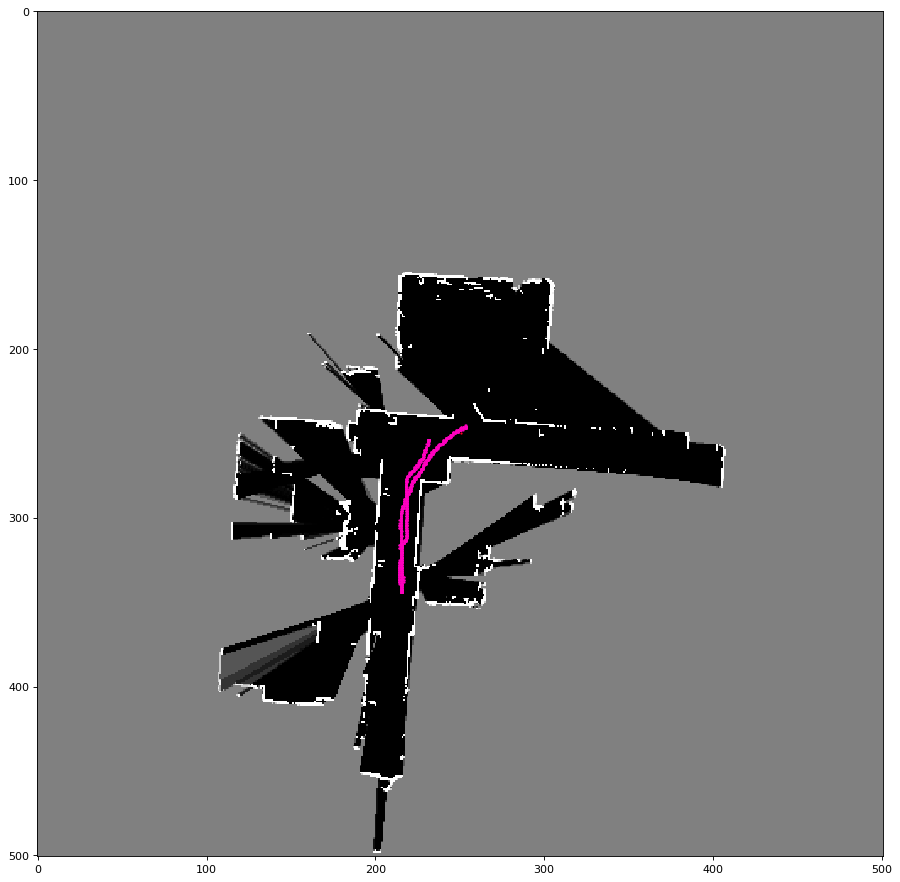

In [6]:
import pylab
indices = slam.coordinate_to_map_index(np.array(states))
plot_map(slam.map_prob, [indices[::5, 0], indices[::5, 1]], 20)

In [7]:
# fig = plt.figure(figsize=(8, 8))
# plt.imshow(np.transpose(slam.map_texture, (1, 0, 2)))
# plt.show()

In [8]:
# fig = plt.figure(figsize=(8, 8))
# plt.imshow(slam.map_texture_trimmed)
# plt.show()